# Bonds exploratory analysis

Bonds are fixed income instruments arising from a loan between an investor and a borrower (usually corporate or governmental). In this notebook we explore the average *yield* of U.S treasury rate bonds with constant maturity over the years. 

In [335]:
%config InlineBackend.figure_format = 'retina'

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

warnings.simplefilter('ignore')
register_matplotlib_converters()

In [2]:
sns.set(rc={'figure.figsize': (12,8)})

## Data munging

In [3]:
data_dir = 'data/'

In [ ]:
dfs = []
reference = {
    'DGS1MO.csv': 'one_month',
    'DGS3MO.csv': 'three_months',
    'DGS1.csv': 'one_year',
    'DGS2.csv': 'two_years',
    'DGS3.csv': 'three_years',
    'DGS5.csv': 'five_years',
    'DGS10.csv': 'ten_years',
    'DGS30.csv': 'thirty_years'
}

for file in os.listdir(data_dir):
    series = reference[file]
    df = pd.read_csv(os.path.join(data_dir, file),
                     names=['date', series],
                     skiprows=1,
                     index_col='date',
                     parse_dates=['date'],
                     na_values='.')
    dfs.append(df)

bonds = pd.concat(dfs, axis=1)
bonds = bonds.reindex(columns=[
    'one_month', 'three_months', 'one_year', 'two_years', 'three_years',
    'five_years', 'ten_years', 'thirty_years'
],
                      copy=False)
bonds.to_csv(os.path.join(data_dir, 'bonds.csv'))

## Exploration

In [4]:
bonds = pd.read_csv(os.path.join(data_dir, 'bonds.csv'), index_col='date', parse_dates=['date'])

In [5]:
bonds.tail()

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
2019-08-23       2.07          1.97      1.73       1.51         1.43   
2019-08-26       2.09          2.01      1.75       1.54         1.47   
2019-08-27       2.07          1.98      1.77       1.53         1.43   
2019-08-28       2.07          1.99      1.74       1.50         1.42   
2019-08-29       2.10          1.99      1.75       1.53         1.44   

            five_years  ten_years  thirty_years  
date                                             
2019-08-23        1.40       1.52          2.02  
2019-08-26        1.43       1.54          2.04  
2019-08-27        1.40       1.49          1.97  
2019-08-28        1.37       1.47          1.94  
2019-08-29        1.40       1.50          1.97

In [6]:
bonds.describe()

one_month  three_months      one_year     two_years   three_years  \
count  4523.000000   9418.000000  14401.000000  10809.000000  14401.000000   
mean      1.289766      3.922607      5.117681      5.303314      5.538407   
std       1.498167      3.123336      3.397248      3.757526      3.259276   
min       0.000000      0.000000      0.080000      0.160000      0.280000   
25%       0.060000      0.960000      2.580000      1.870000      3.280000   
50%       0.880000      3.980000      5.140000      5.220000      5.540000   
75%       1.980000      5.840000      7.000000      7.680000      7.410000   
max       5.270000     15.490000     17.310000     16.950000     16.590000   

         five_years     ten_years  thirty_years  
count  14401.000000  14401.000000   9637.000000  
mean       5.804956      6.142178      6.765167  
std        3.111197      2.888204      3.031926  
min        0.560000      1.370000      1.940000  
25%        3.640000      4.070000      4.270000  
50%        5.720000      5.900000      6.570000  
75%        7.640000      7.790000      8.620000  
max       16.270000     15.840000     15.210000

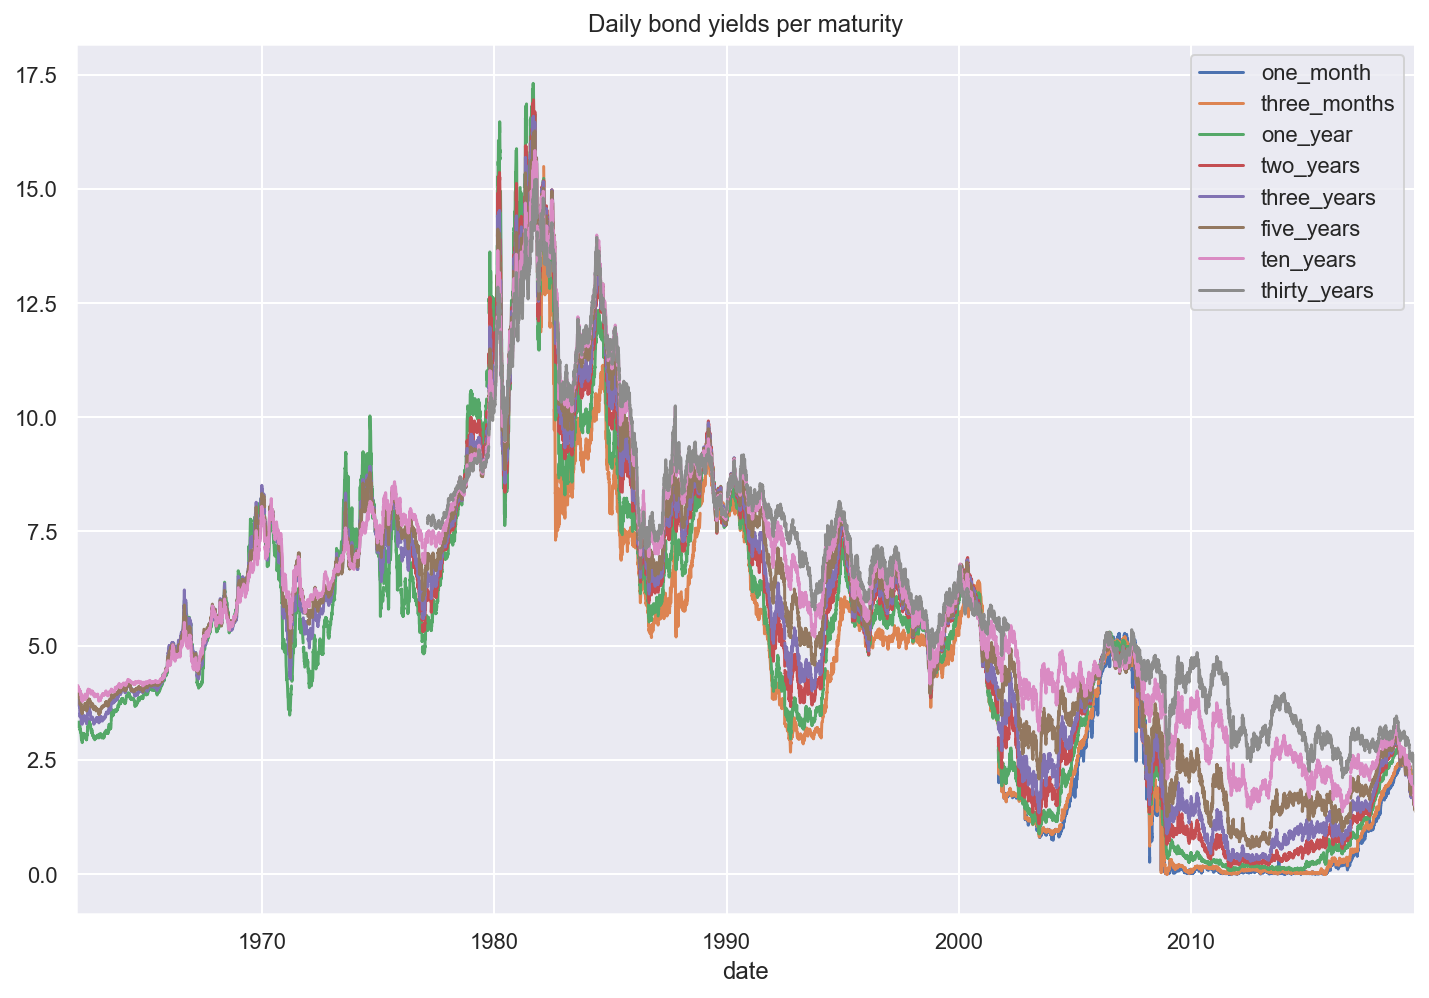

In [8]:
bonds.plot(title='Daily bond yields per maturity');

We can see that the yield values skyrocketed at the beginning of the eighties because of the [high inflation](https://www.usinflationcalculator.com/inflation/historical-inflation-rates/) experienced at the time, and then experienced a gradual decline across all maturity levels. By 2008, low maturity bonds reached almost zero yield due to the crisis. On the other hand, high maturity bonds were less affected because of their long term nature, though they still continued to drop throughout the next decade. The plot also shows how higher maturity bonds tend to have a higher associated yield as one would expect, although this might not be the case when zooming into smaller timeframes. Time periods where lower maturity bonds have a higher yield (i.e, where the yield curves are *inverted*) tend to be associated with economic recession.

We'll now transform the data into a tidy (long) format to visualize it with `seaborn`.

In [17]:
bonds_tidy = bonds.reset_index().melt(id_vars='date', var_name='maturity', value_name='yield')
bonds_tidy.tail()

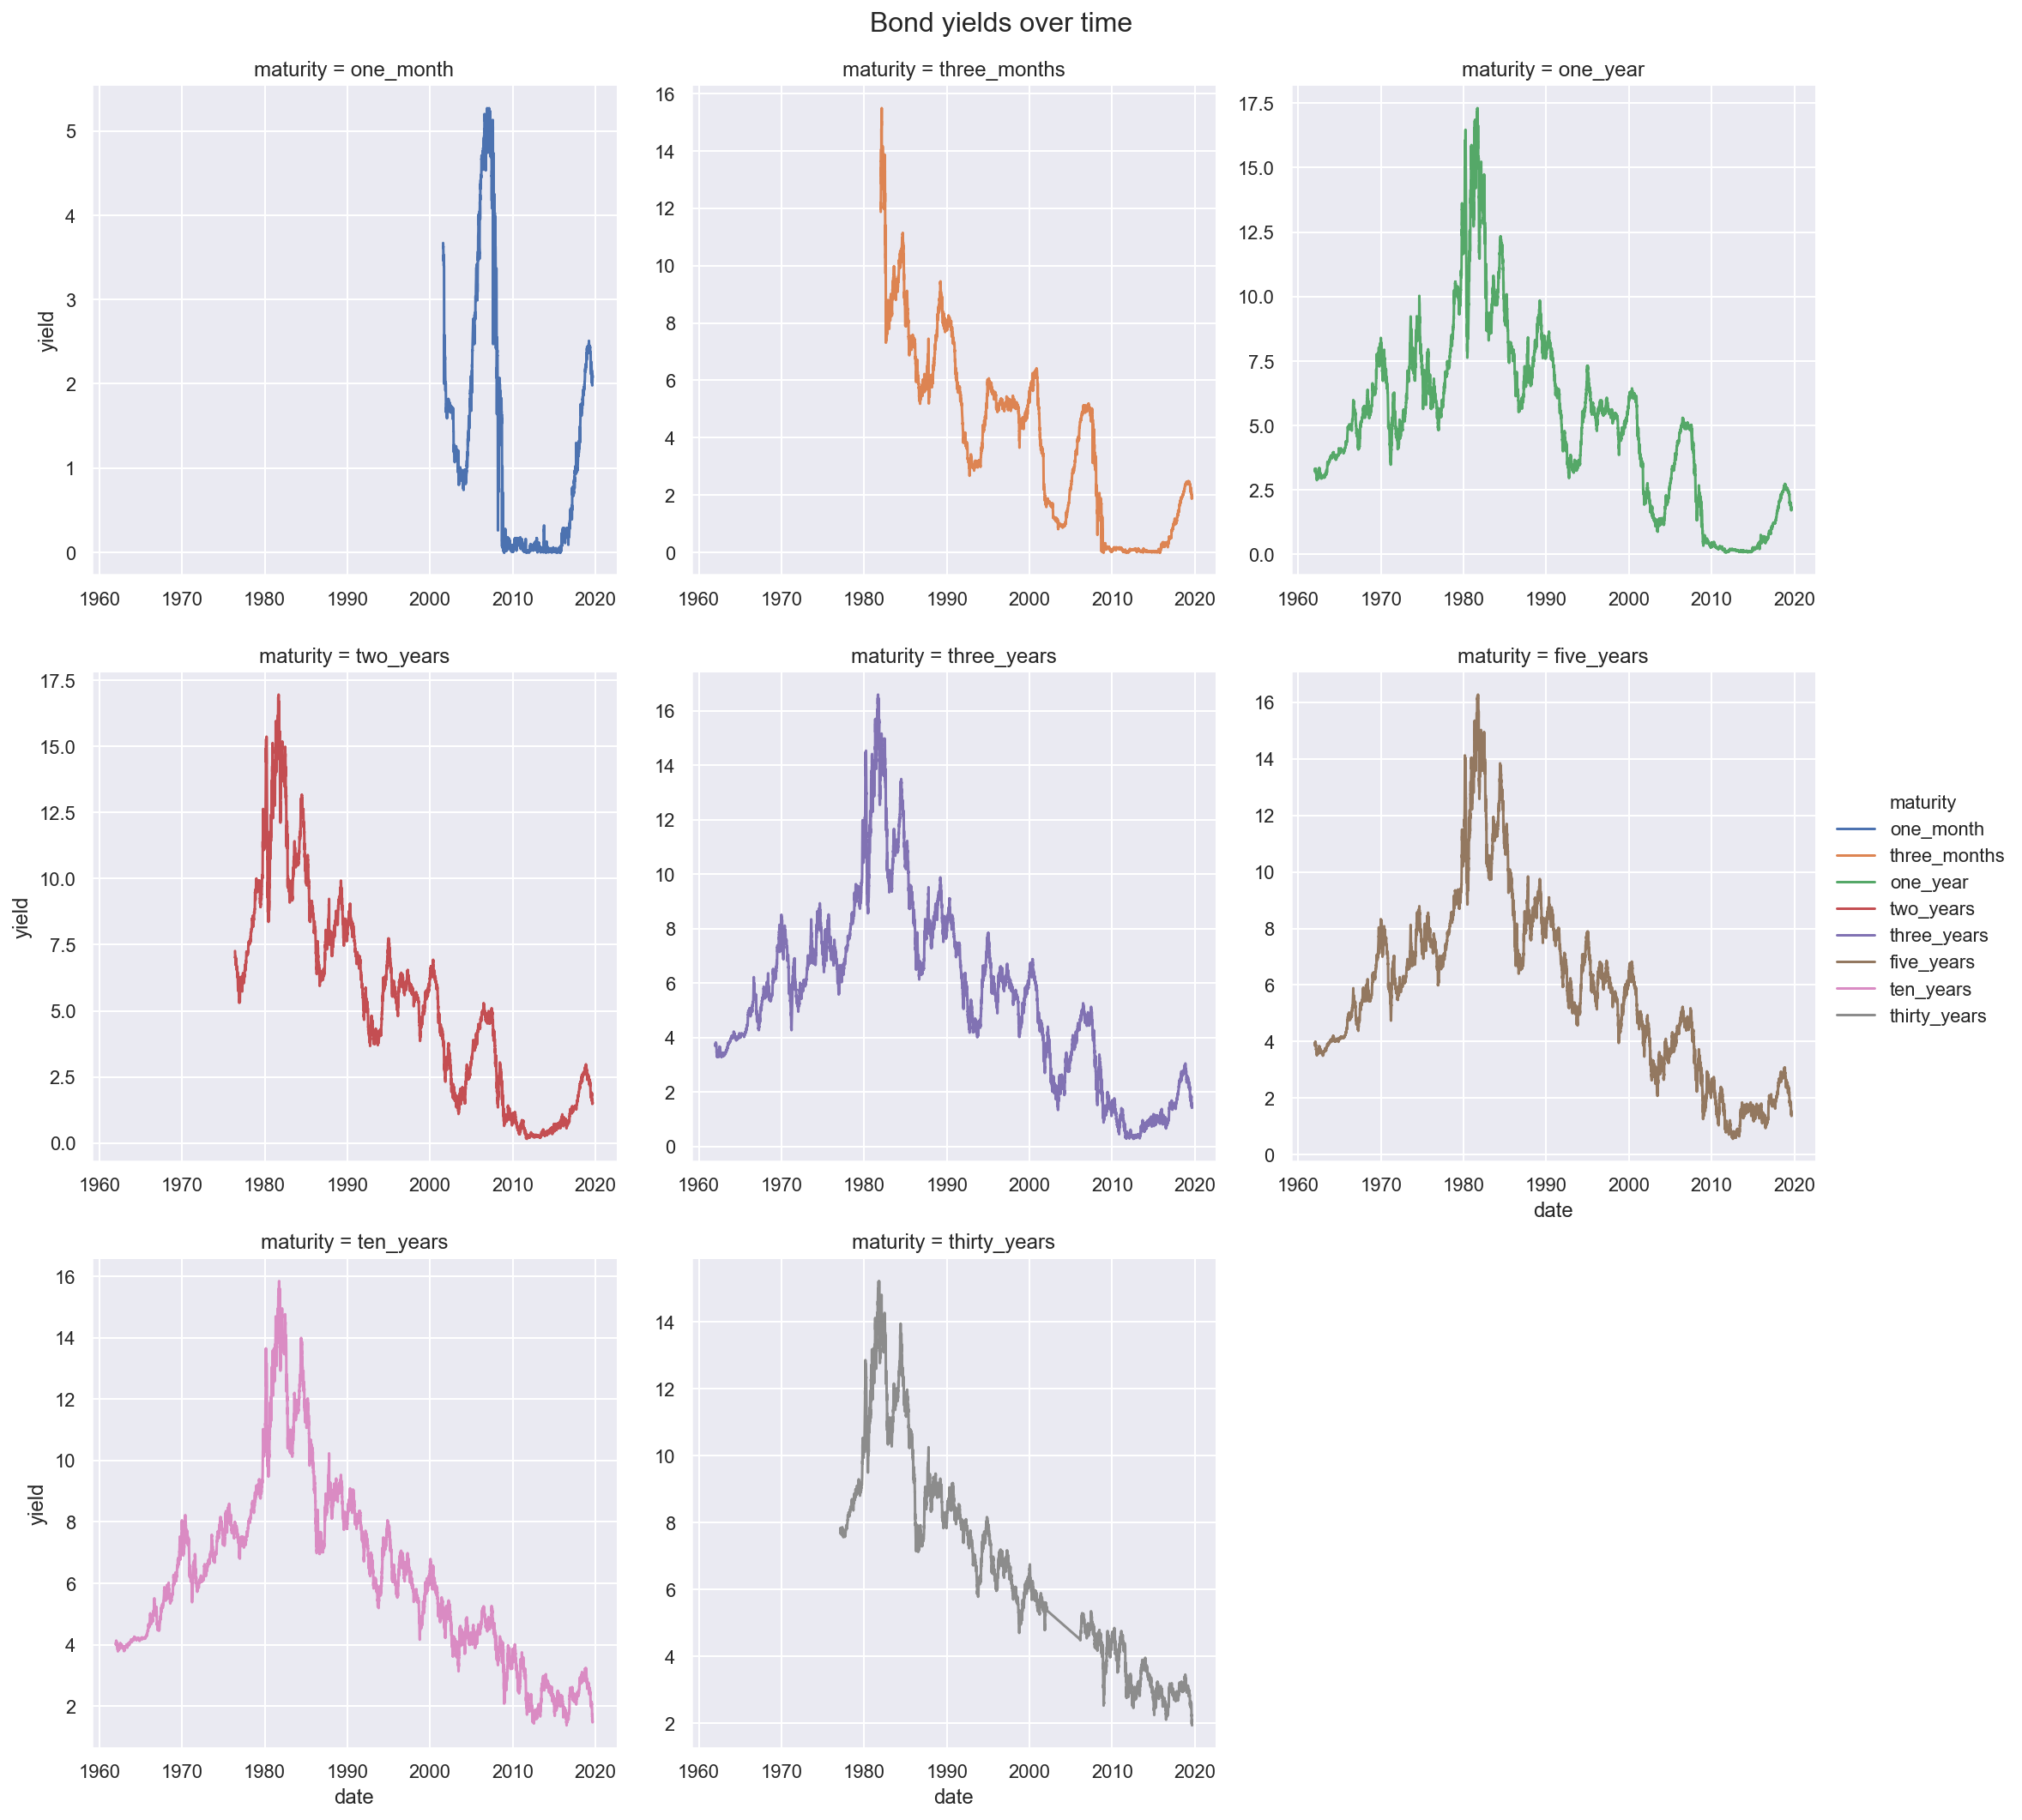

In [19]:
g = sns.relplot(x='date', y='yield', col='maturity', hue='maturity',
            facet_kws=dict(sharey=False, sharex=True), col_wrap=3,
            kind='line', data=bonds_tidy)

g.fig.suptitle('Bond yields over time', size=16)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
g.fig.subplots_adjust(top=.94, hspace=0.2);

To better visualize how higher maturity bonds typically have a higher yield, we plot the average yield by maturity from 2002 (when the data for one month maturity starts) to the present.

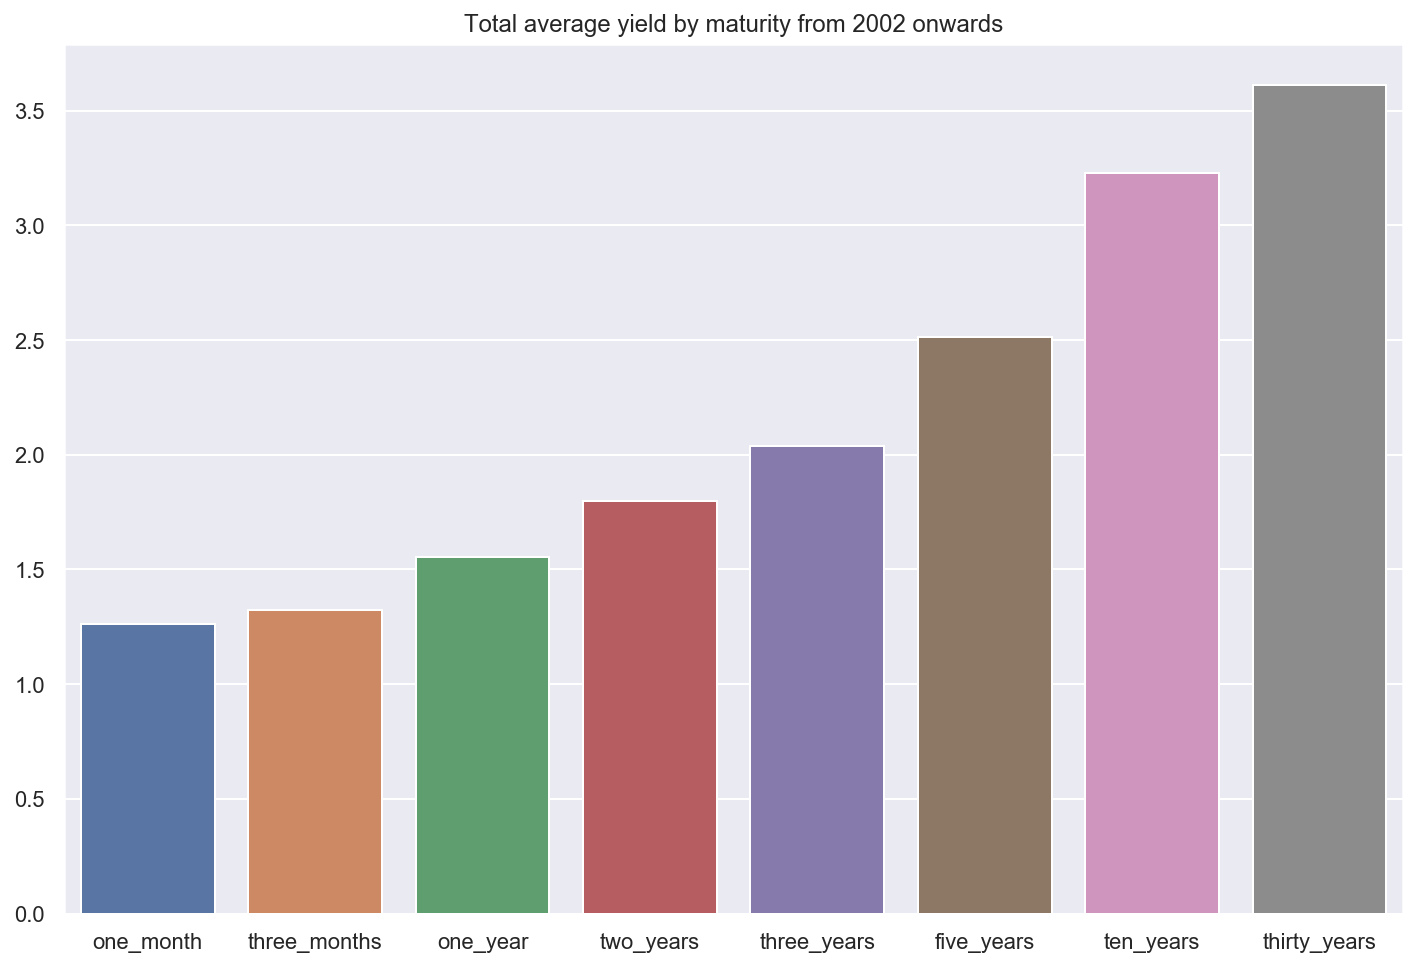

In [9]:
bonds_2002_onwards = bonds['2002':]
sns.barplot(x=bonds_2002_onwards.mean().index,y=bonds_2002_onwards.mean().values);
plt.title('Total average yield by maturity from 2002 onwards');

Now we plot the *yearly* average yield by maturity starting in 2002. The color palette remains consistent with the previous one.

In [125]:
bonds_yearly_mean = bonds['2002':].resample('Y').mean()
bonds_yearly_mean['year'] = bonds_yearly_mean.index.year
bonds_yearly_mean_tidy = bonds_yearly_mean.melt(id_vars='year', var_name='maturity', value_name='mean yield')

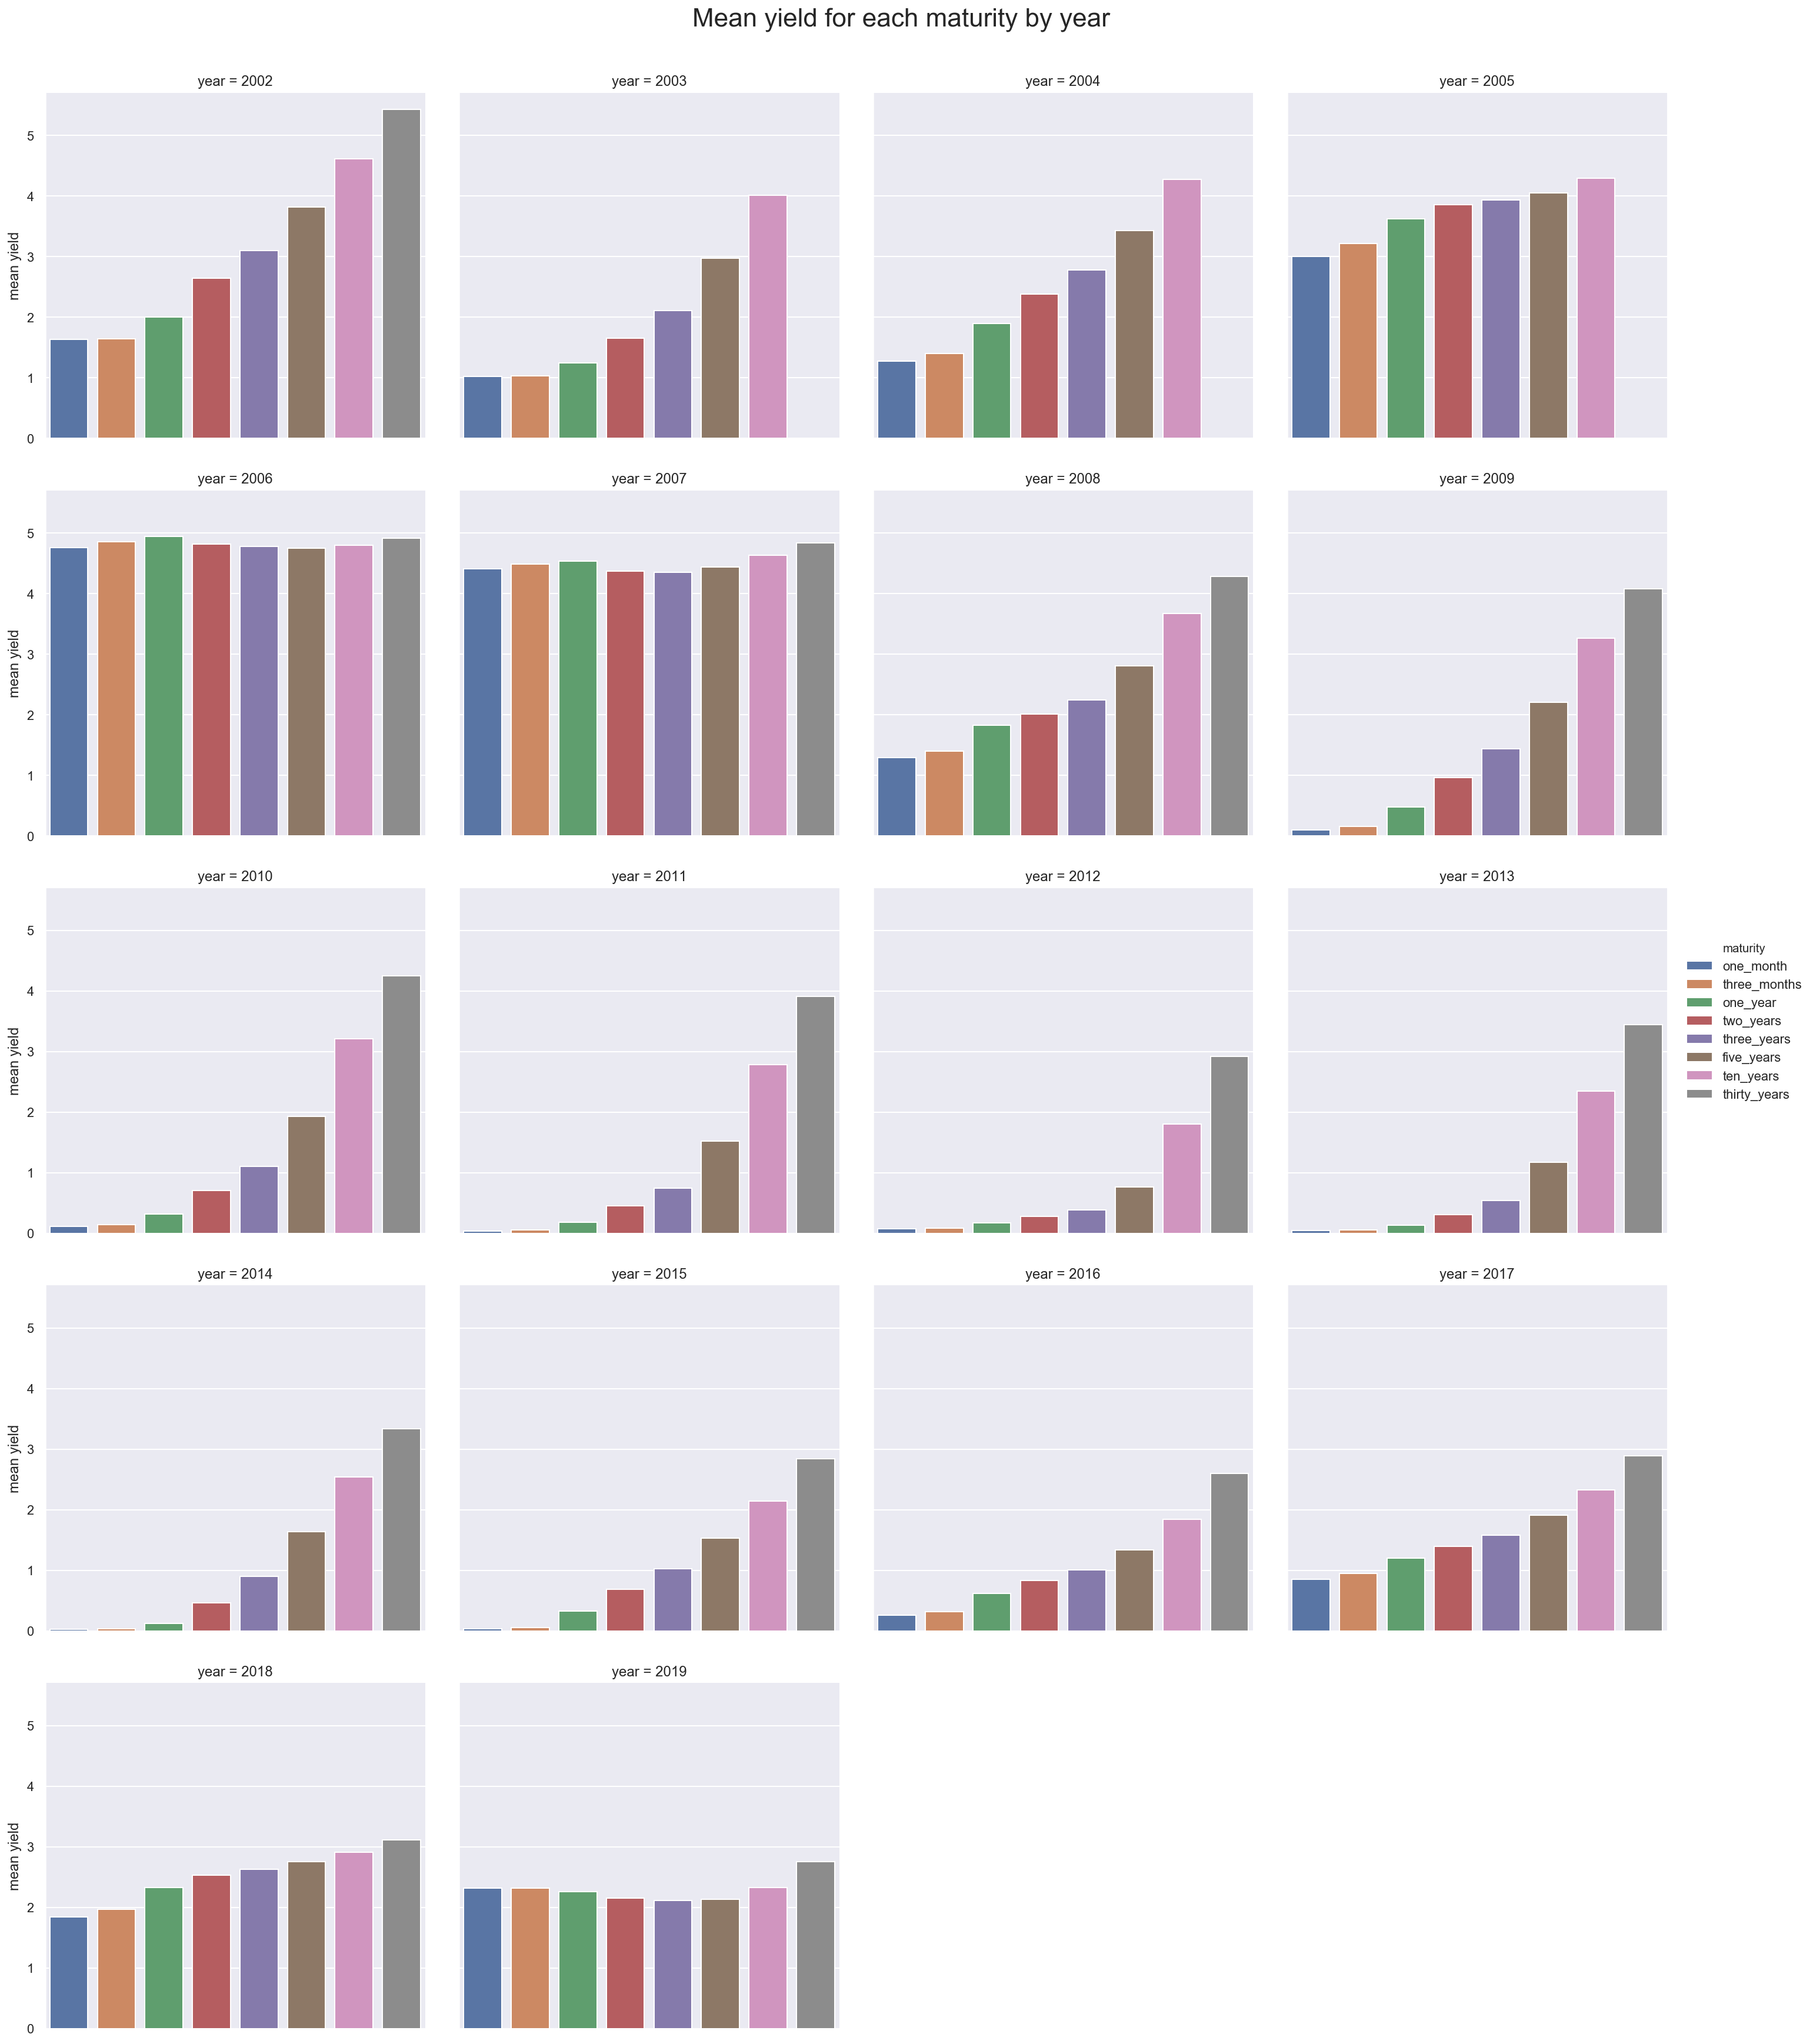

In [124]:
g = sns.catplot(x='maturity', y='mean yield', col='year', kind='bar', data=bonds_yearly_mean_tidy, col_wrap=4)

ax, *_ = g.axes
bars = ax.containers[0]
labels = [label for _tick, _pos, label in ax.xaxis.iter_ticks()]
legend = dict(zip(labels, bars))

for ax in g.axes.flatten():
    ax.tick_params(labelbottom=False)
    ax.xaxis.label.set_visible(False)

g.add_legend(legend, title='maturity')
g.fig.subplots_adjust(top=.94)
g.fig.suptitle('Mean yield for each maturity by year', size=22);

Notice how the barplots flatten in certain time periods, namely 2006, 2007 and 2019. We will explore this more in the next section.

### Yield curves

Let's plot the [yield curves](https://www.investopedia.com/terms/y/yieldcurve.asp) for each month in 2005. We'll have a look at the **three months**, **one year** and **ten year** maturities.

In [12]:
bonds_2005 = bonds.loc['2005']
bonds_2005['day'] = bonds_2005.index.day
bonds_2005['month'] = bonds_2005.index.month_name()
bonds_2005.head()

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
2005-01-03       1.99          2.32      2.79       3.10         3.28   
2005-01-04       2.05          2.33      2.82       3.20         3.38   
2005-01-05       2.04          2.33      2.83       3.22         3.39   
2005-01-06       2.04          2.31      2.82       3.18         3.36   
2005-01-07       2.03          2.32      2.82       3.20         3.40   

            five_years  ten_years  thirty_years  day    month  
date                                                           
2005-01-03        3.64       4.23           NaN    3  January  
2005-01-04        3.72       4.29           NaN    4  January  
2005-01-05        3.73       4.29           NaN    5  January  
2005-01-06        3.71       4.29           NaN    6  January  
2005-01-07        3.73       4.29           NaN    7  January

In [13]:
bonds_2005_tidy = bonds_2005.melt(id_vars=['day', 'month'], var_name='maturity', value_name='yield')

# We'll plot only 10y, 1y, 3m bond series
bonds_2005_subset = bonds_2005_tidy.loc[bonds_2005_tidy['maturity'].isin(['three_months', 'one_year', 'ten_years'])]

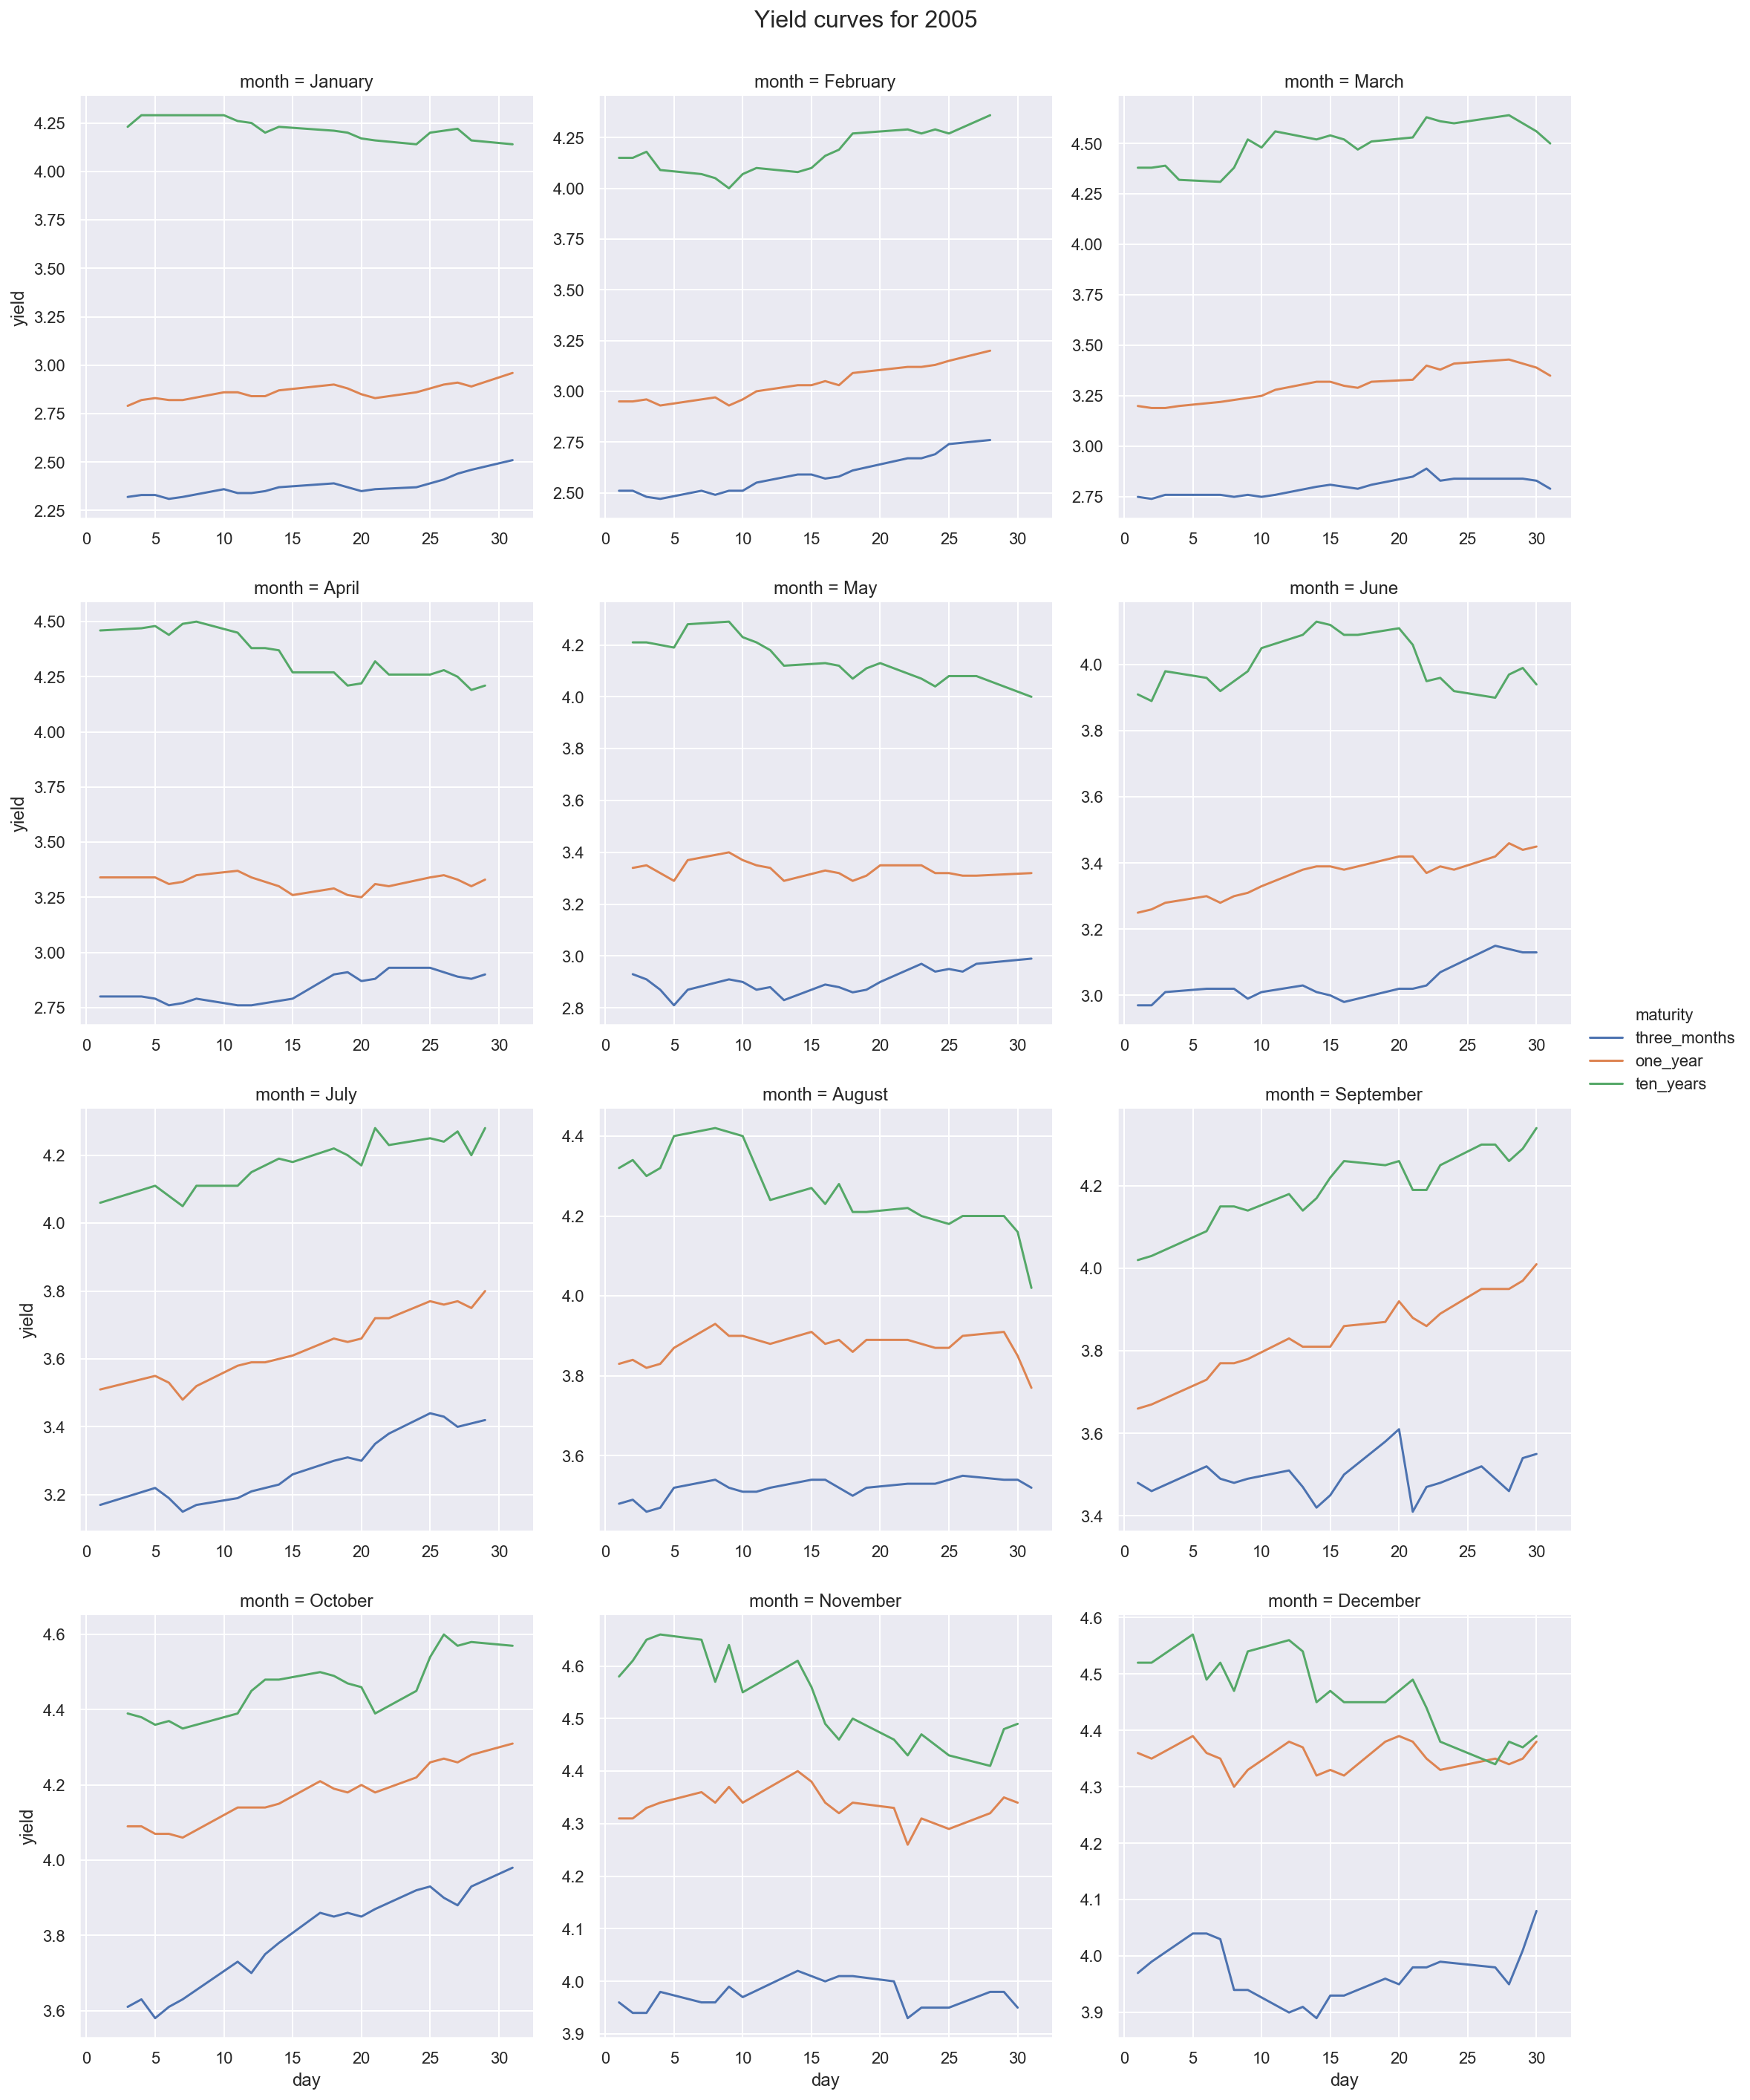

In [14]:
g = sns.relplot(x='day', y='yield', col='month', hue='maturity',
            facet_kws=dict(sharey=False, sharex=True), col_wrap=3,
            kind='line', data=bonds_2005_subset)

g.fig.suptitle('Yield curves for 2005', size=16)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
g.fig.subplots_adjust(top=.94, hspace=0.2);

As we can see, 2005 featured pretty [normal yield curves](https://www.investopedia.com/terms/n/normalyieldcurve.asp), with longer maturities having higher yields (as expected because of the [time value of money](https://www.investopedia.com/terms/t/timevalueofmoney.asp)). As the year progressed, the three of them started getting closer, anticipating the 2008 economic crisis.  
Let's plot the yield curves for 2006 to see how this continued. 

In [15]:
bonds_2006 = bonds.loc['2006']
bonds_2006['day'] = bonds_2006.index.day
bonds_2006['month'] = bonds_2006.index.month_name()
bonds_2006.head()

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
2006-01-02        NaN           NaN       NaN        NaN          NaN   
2006-01-03       4.05          4.16      4.38       4.34         4.30   
2006-01-04       4.03          4.19      4.35       4.31         4.28   
2006-01-05       4.05          4.20      4.36       4.32         4.29   
2006-01-06       4.06          4.22      4.38       4.36         4.32   

            five_years  ten_years  thirty_years  day    month  
date                                                           
2006-01-02         NaN        NaN           NaN    2  January  
2006-01-03        4.30       4.37           NaN    3  January  
2006-01-04        4.28       4.36           NaN    4  January  
2006-01-05        4.29       4.36           NaN    5  January  
2006-01-06        4.32       4.38           NaN    6  January

In [16]:
bonds_2006_tidy = bonds_2006.melt(id_vars=['day', 'month'], var_name='maturity', value_name='yield')

# We'll plot only 10y, 1y, 3m bond series
bonds_2006_subset = bonds_2006_tidy.loc[bonds_2006_tidy['maturity'].isin(['three_months', 'one_year', 'ten_years'])]

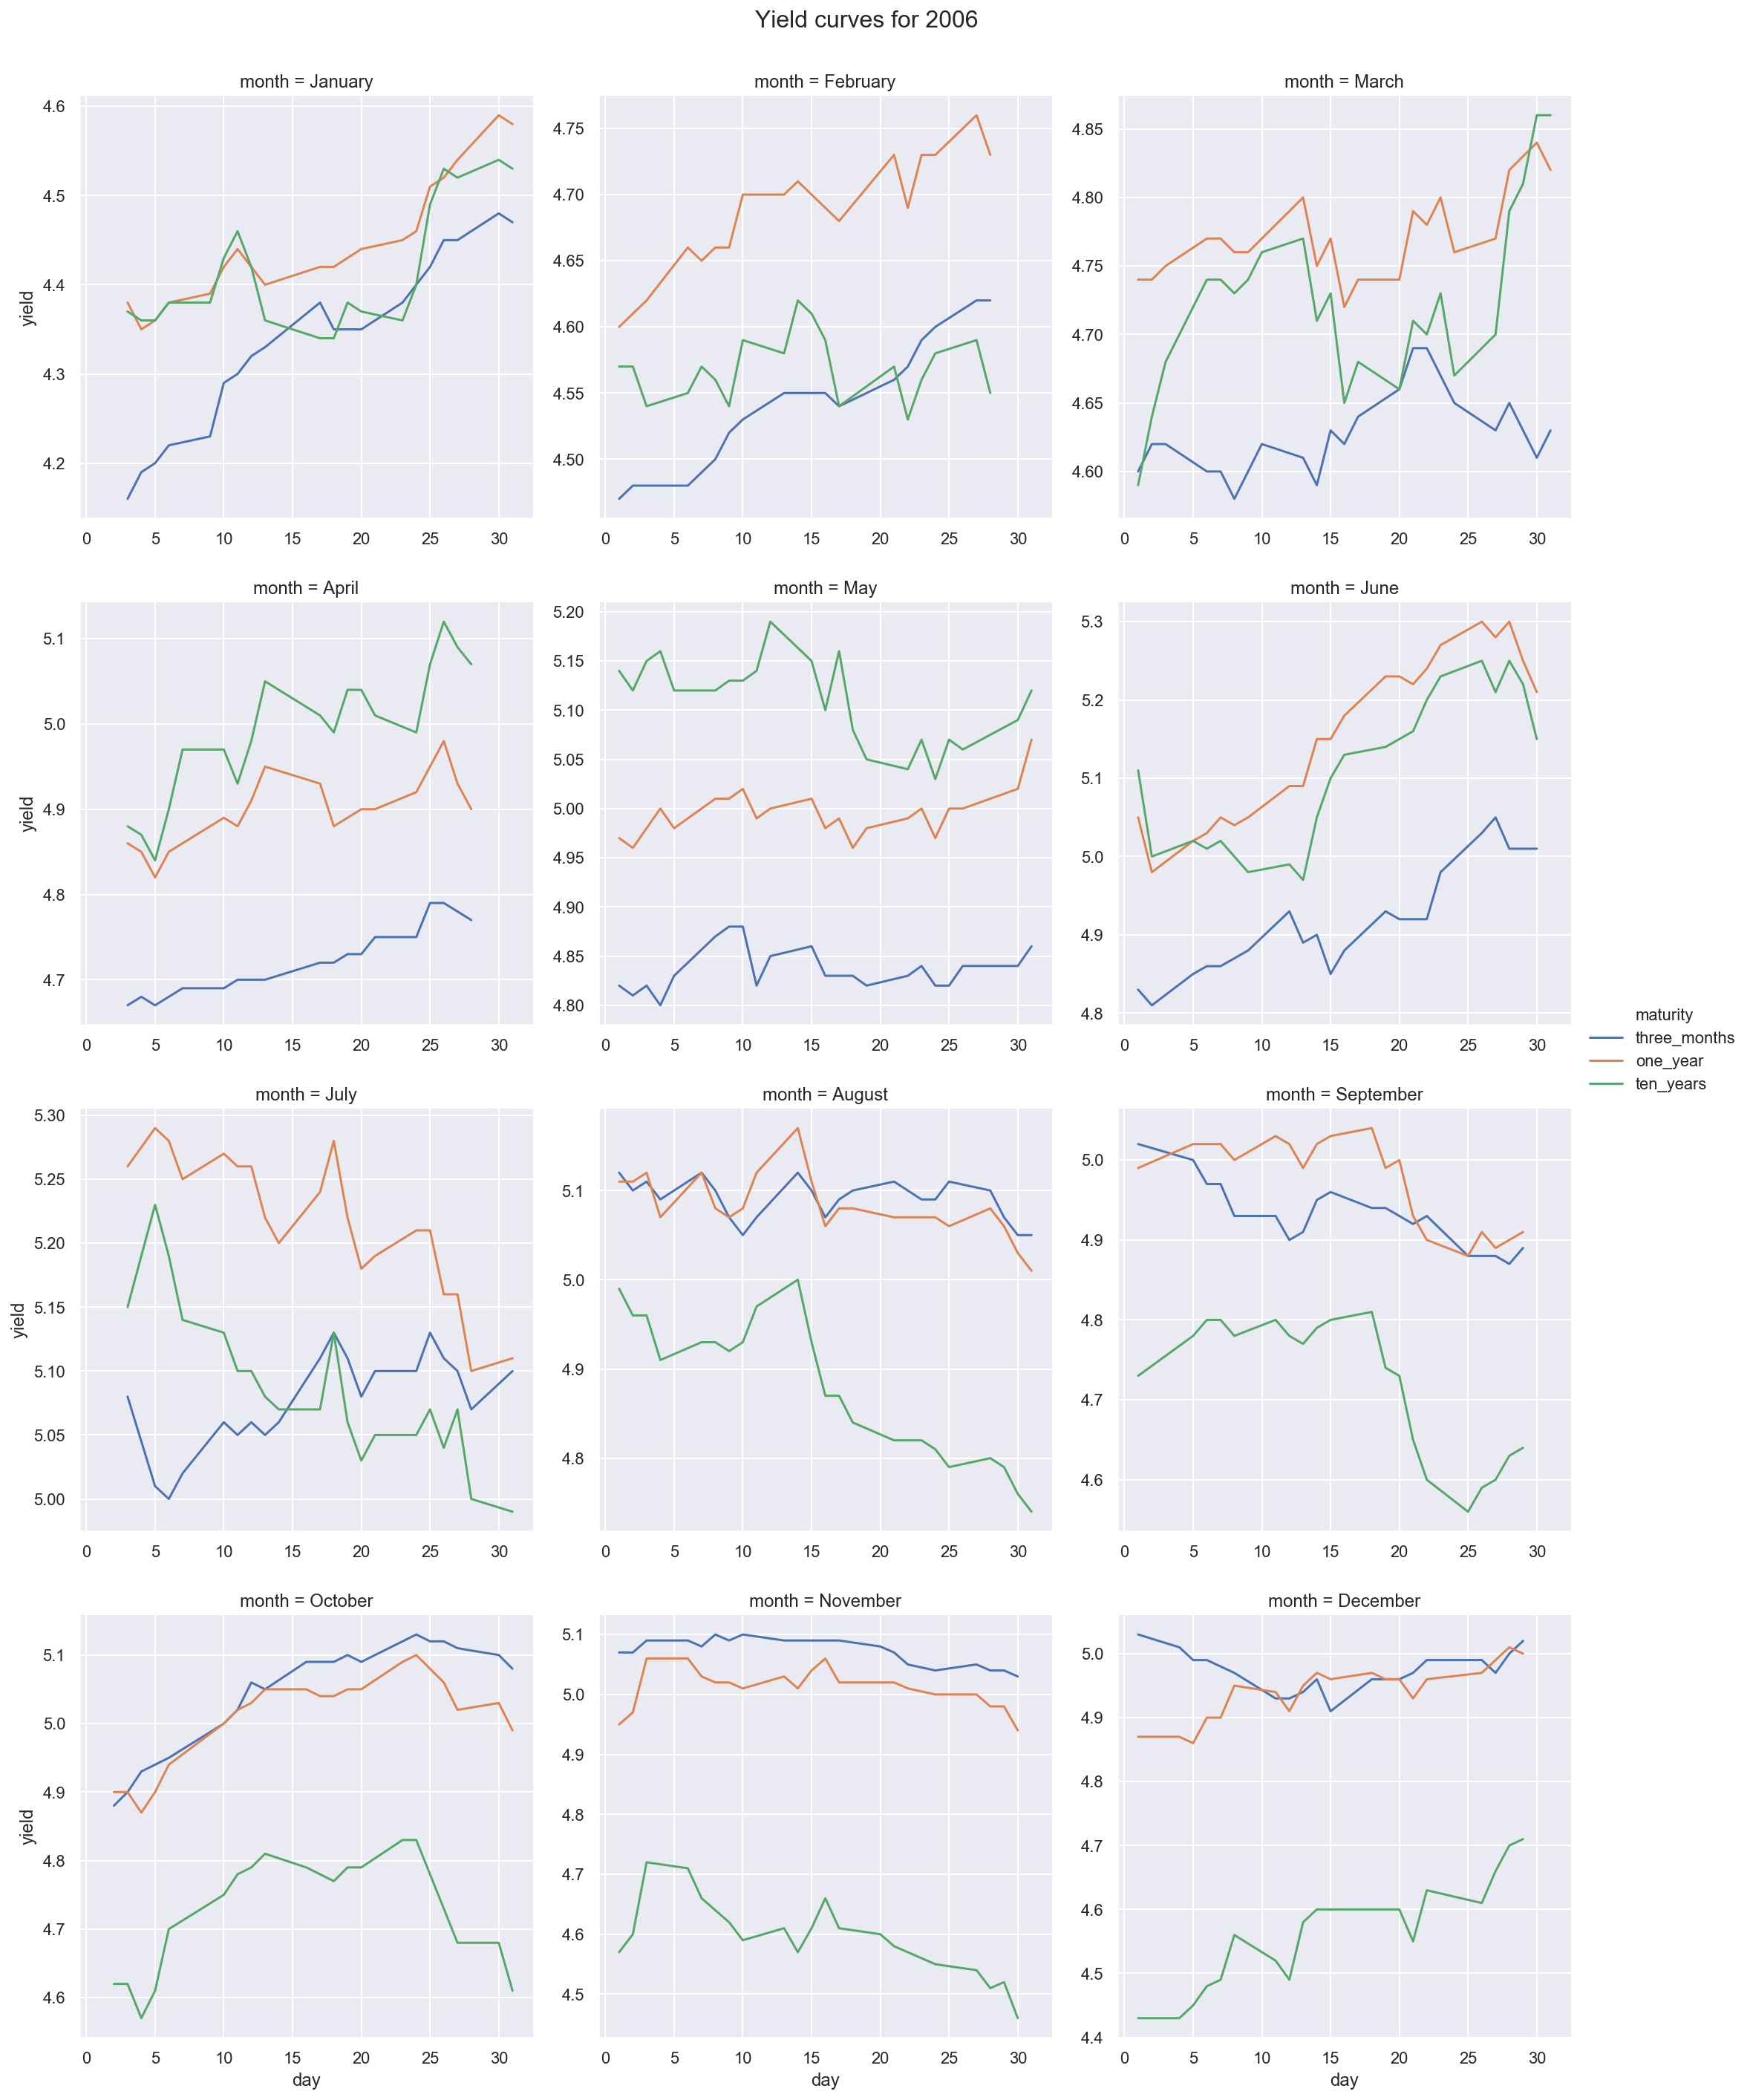

In [17]:
g = sns.relplot(x='day', y='yield', col='month', hue='maturity',
            facet_kws=dict(sharey=False, sharex=True), col_wrap=3,
            kind='line', data=bonds_2006_subset)

g.fig.suptitle('Yield curves for 2006', size=16)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
g.fig.subplots_adjust(top=.94, hspace=0.2);

Throughout 2006, yield curves continued to [invert](https://www.investopedia.com/terms/i/invertedyieldcurve.asp), with three month maturity bonds having the highest yield and ten year bonds the lowest by the end of the year. Let's now compare this to the 2019 curves.

In [18]:
bonds_2019 = bonds.loc['2019']
bonds_2019['day'] = bonds_2019.index.day
bonds_2019['month'] = bonds_2019.index.month_name()
bonds_2019.head()

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
2019-01-01        NaN           NaN       NaN        NaN          NaN   
2019-01-02       2.40          2.42      2.60       2.50         2.47   
2019-01-03       2.42          2.41      2.50       2.39         2.35   
2019-01-04       2.40          2.42      2.57       2.50         2.47   
2019-01-07       2.42          2.45      2.58       2.53         2.51   

            five_years  ten_years  thirty_years  day    month  
date                                                           
2019-01-01         NaN        NaN           NaN    1  January  
2019-01-02        2.49       2.66          2.97    2  January  
2019-01-03        2.37       2.56          2.92    3  January  
2019-01-04        2.49       2.67          2.98    4  January  
2019-01-07        2.53       2.70          2.99    7  January

In [19]:
bonds_2019_tidy = bonds_2019.melt(id_vars=['day', 'month'], var_name='maturity', value_name='yield')

In [20]:
bonds_2019_tidy.head()

day    month   maturity  yield
0    1  January  one_month    NaN
1    2  January  one_month   2.40
2    3  January  one_month   2.42
3    4  January  one_month   2.40
4    7  January  one_month   2.42

In [21]:
# We'll plot only 10y, 1y, 3m bond series
bonds_2019_subset = bonds_2019_tidy.loc[bonds_2019_tidy['maturity'].isin(['three_months', 'one_year', 'ten_years'])]

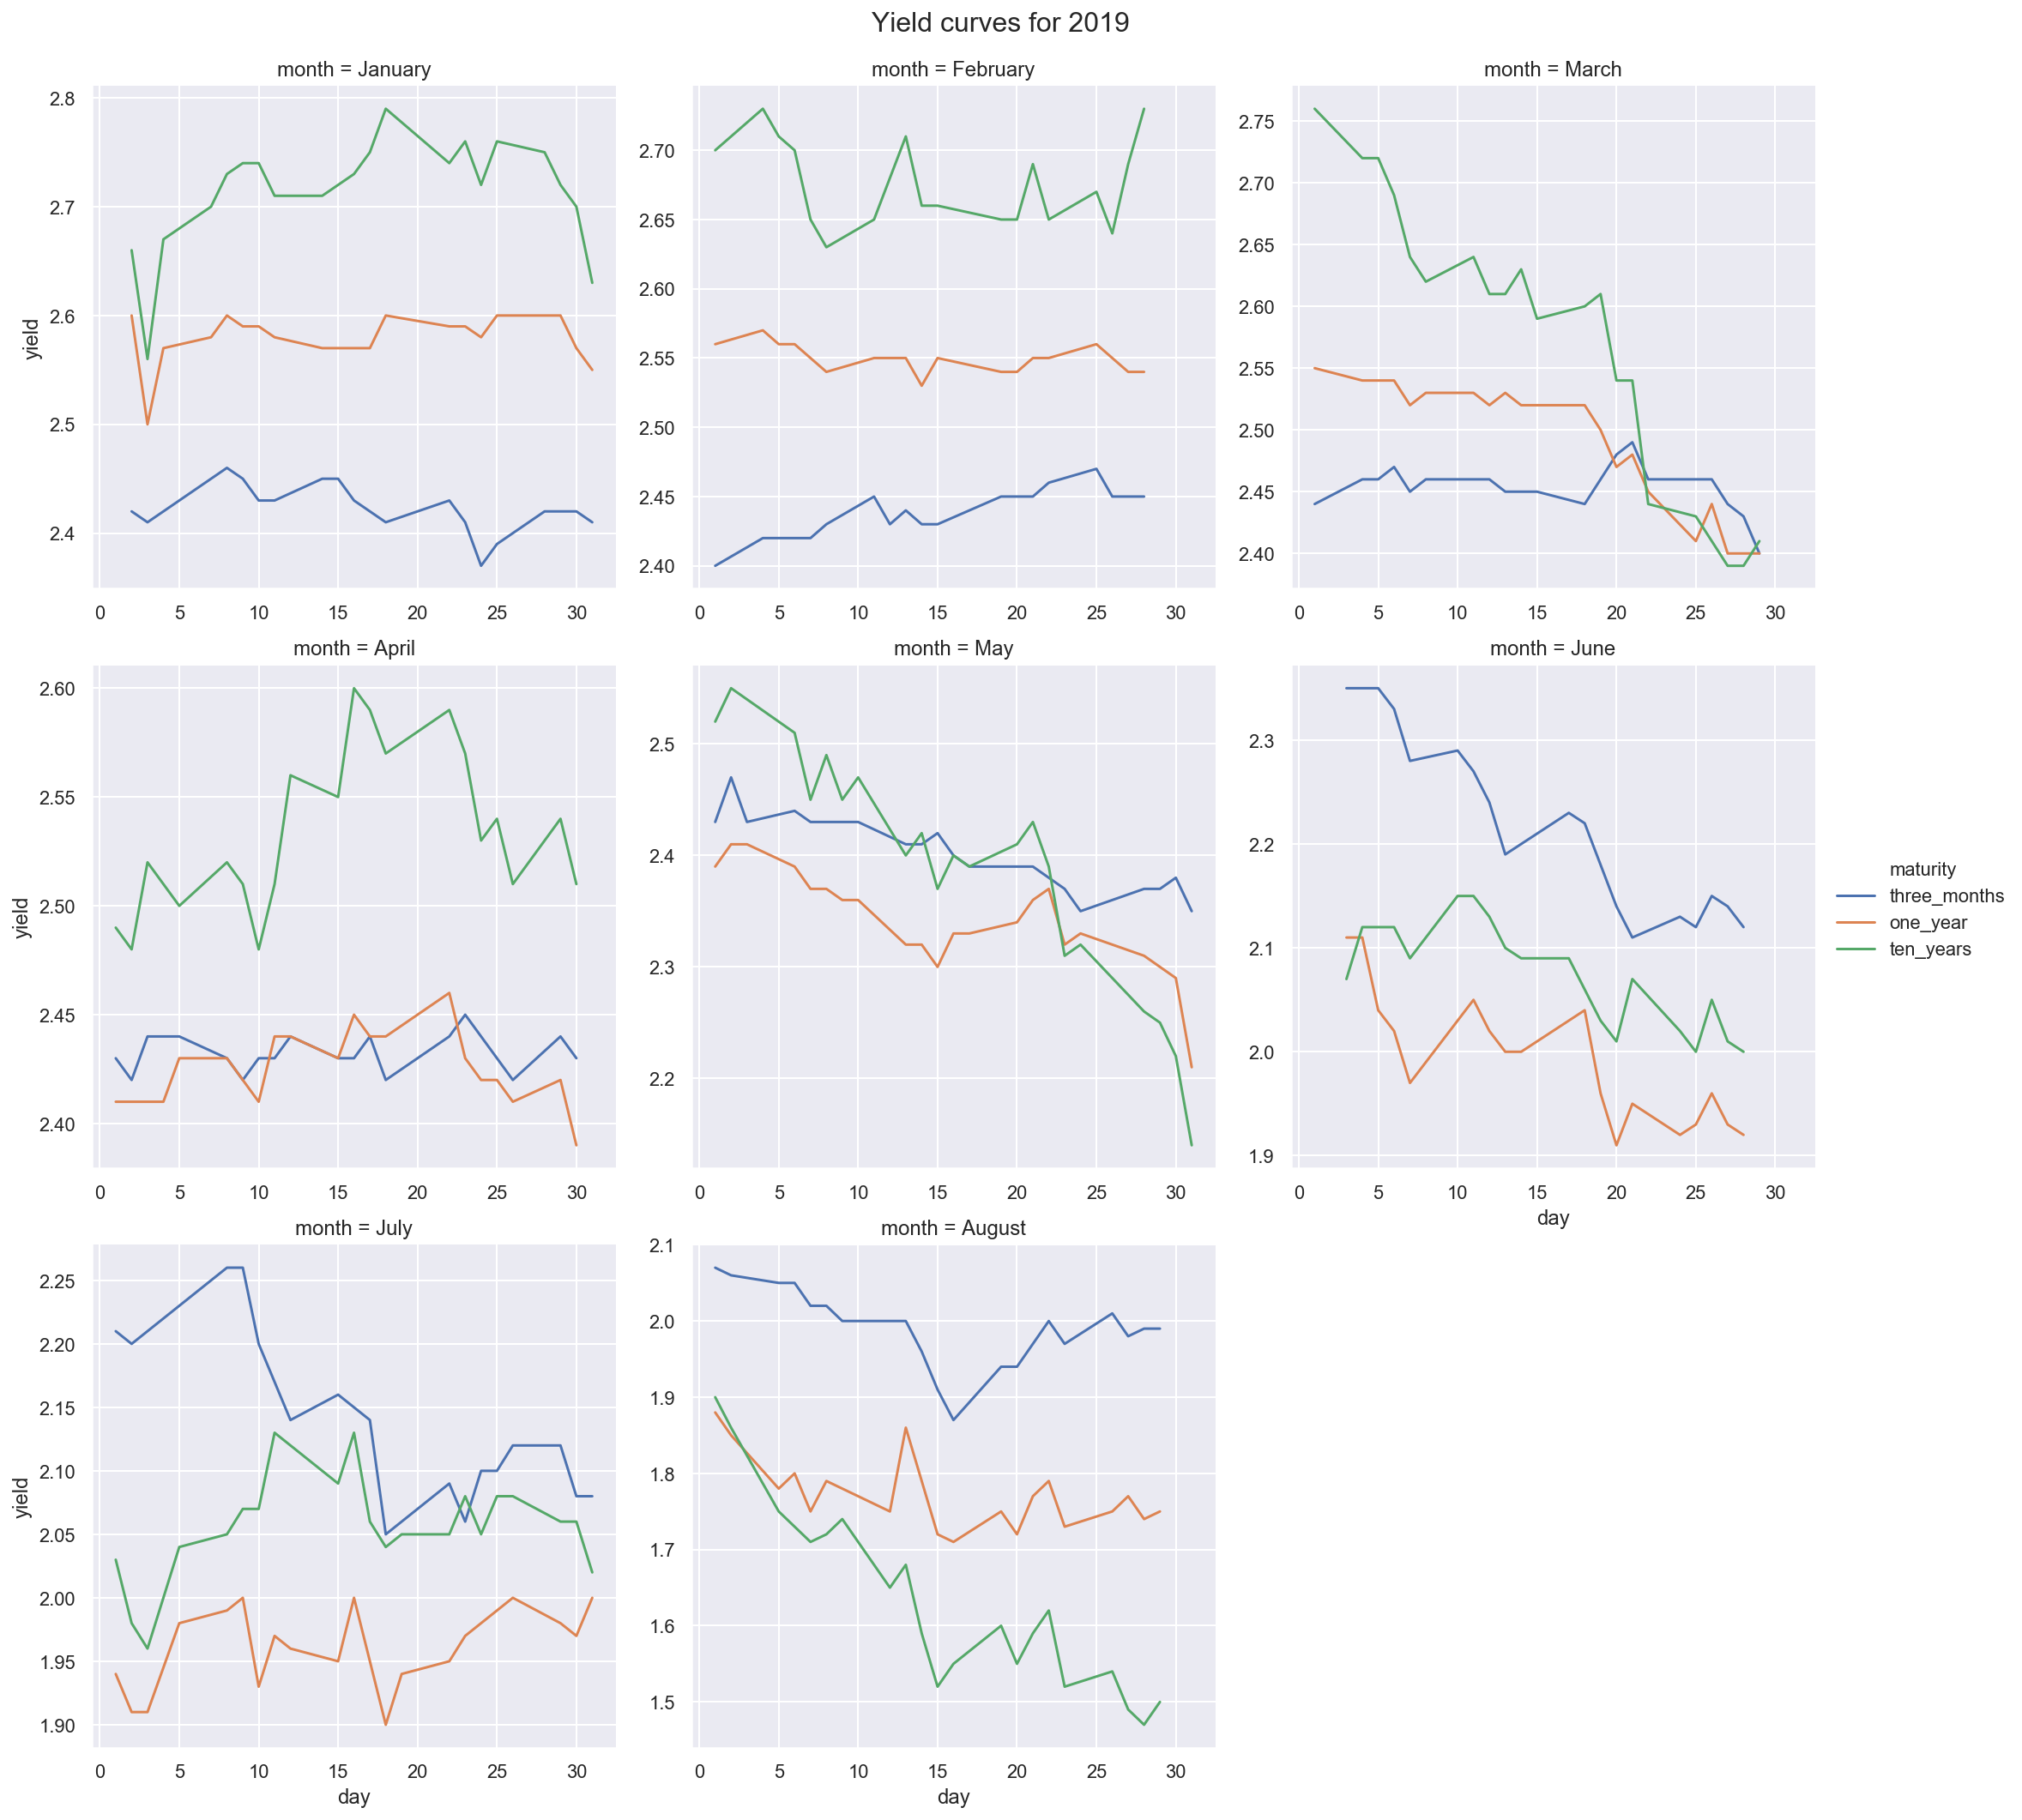

In [22]:
g = sns.relplot(x='day', y='yield', col='month', hue='maturity',
            facet_kws=dict(sharey=False, sharex=True), col_wrap=3,
            kind='line', data=bonds_2019_subset)

g.fig.suptitle('Yield curves for 2019', size=16)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
g.fig.subplots_adjust(top=.94);

In a similar fashion to 2006, yield curves are experiencing a turbulent year as they start inverting. There is [growing concern](https://www.washingtonpost.com/business/2019/08/14/recession-watch-what-is-an-inverted-yield-curve-why-does-it-matter/) that this might be a sign of incoming recession as it has been in the past.

### Outliers

We are interested in the days were bond yields moved three standard deviations from their mean. We'll begin calculating the respective 30-day trailing means and stds.

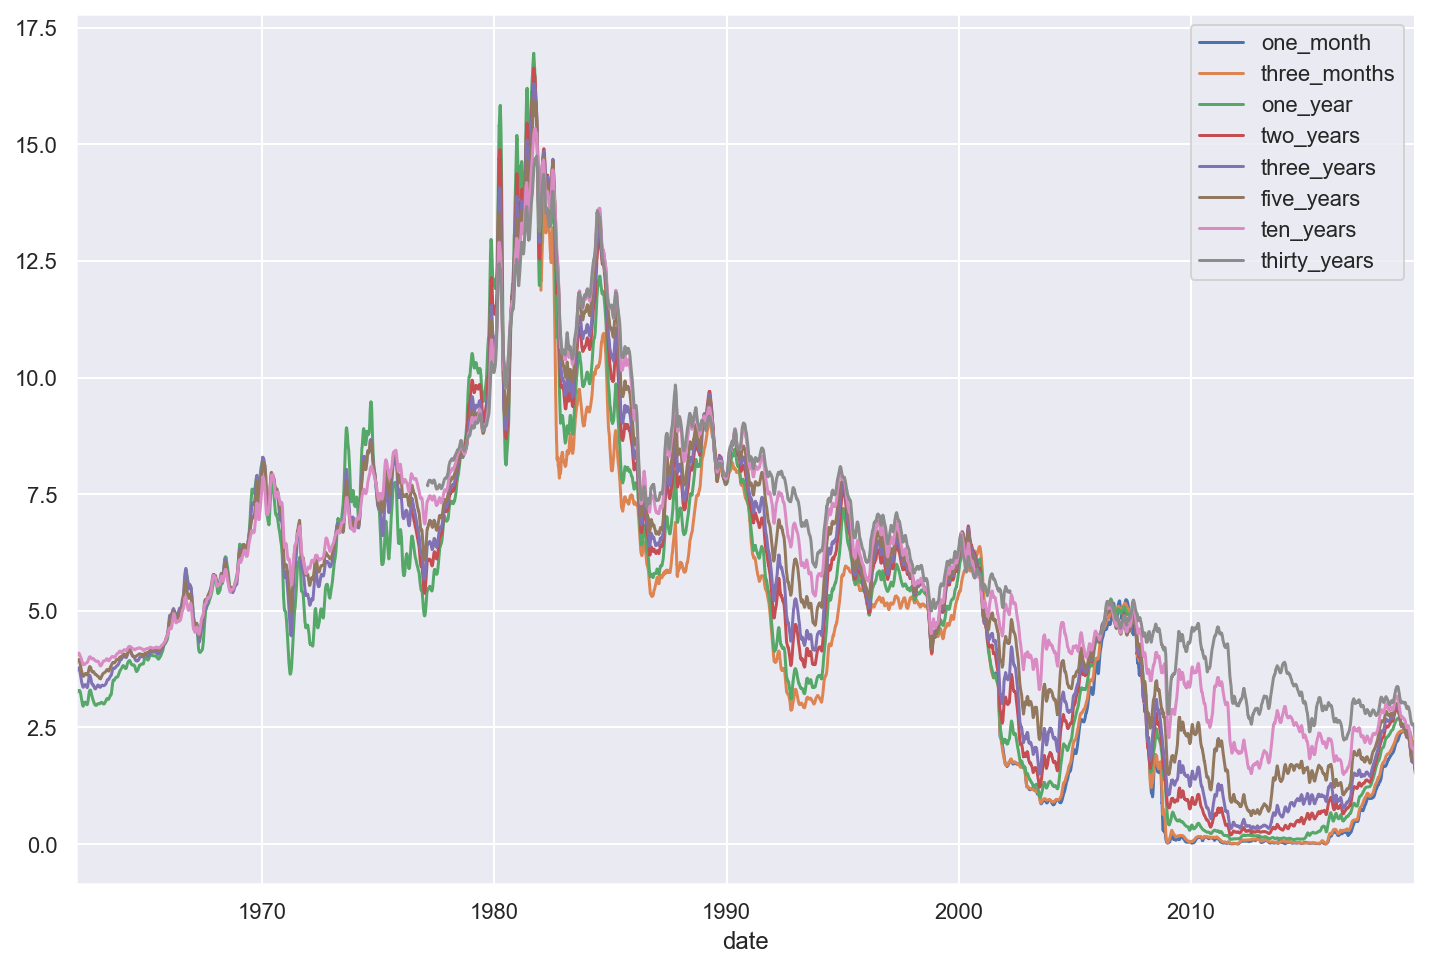

In [406]:
bond_30_day_means = bonds.rolling(window='30D').mean()
bond_30_day_means.plot();

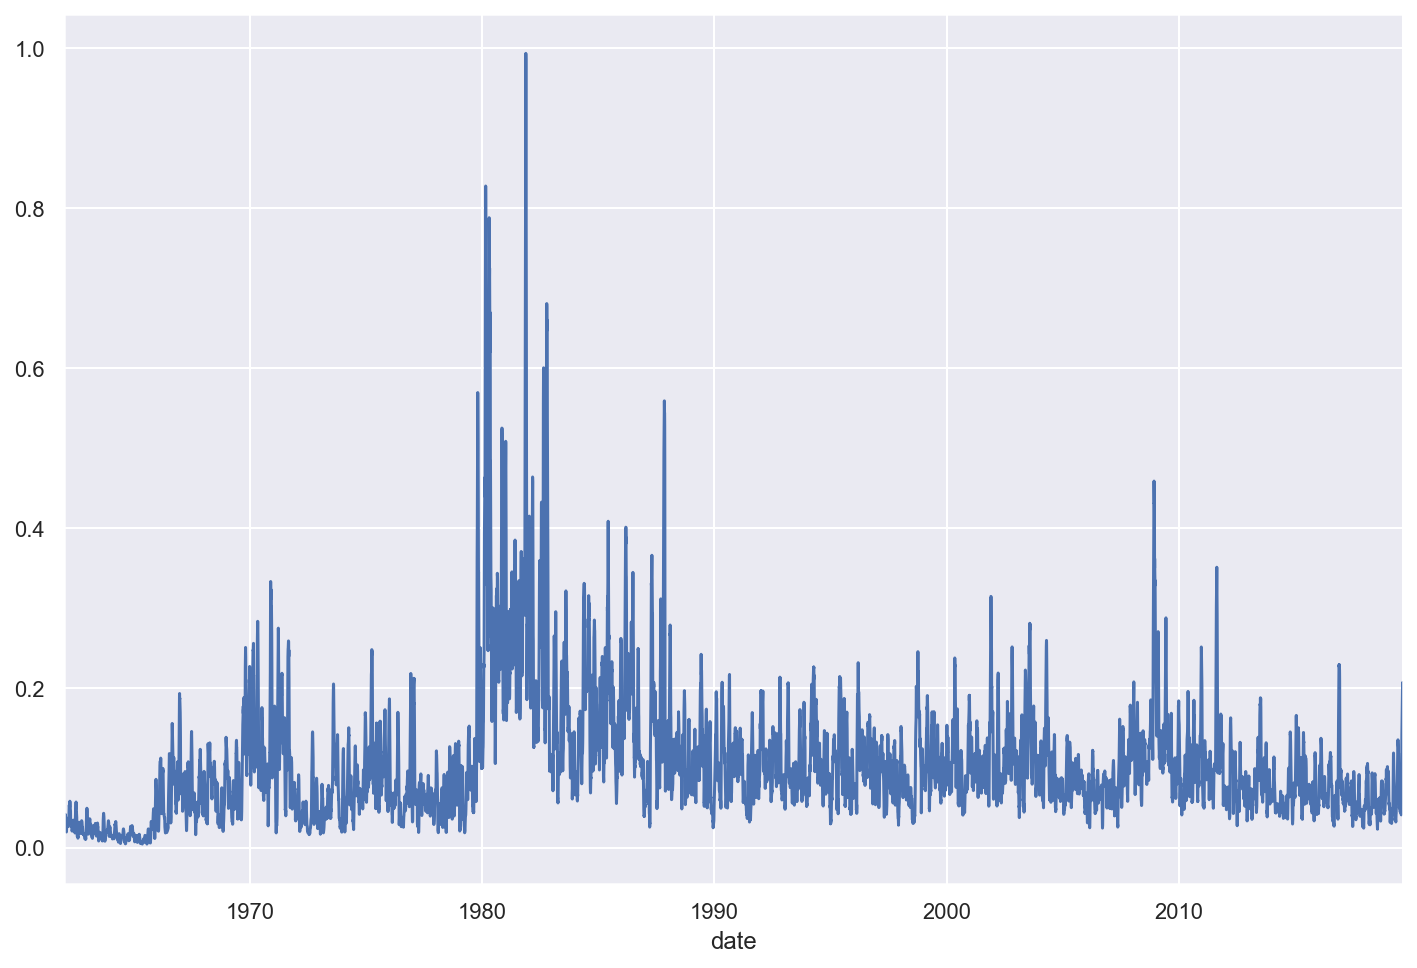

In [407]:
bond_30_day_stds = bonds.rolling(window='30D').std()
bond_30_day_stds['ten_years'].plot();

In [408]:
outliers = bonds[(bonds - bond_30_day_means).abs() >= 3 * bond_30_day_stds]

In [412]:
mask = (bonds - bond_30_day_means).abs() >= 3 * bond_30_day_stds

In [417]:
monthly_outliers.tail()

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
2019-04-30          0             0         0          0            0   
2019-05-31          0             1         0          0            0   
2019-06-30          1             0         1          0            0   
2019-07-31          0             0         0          0            0   
2019-08-31          0             0         1          1            1   

            five_years  ten_years  thirty_years  
date                                             
2019-04-30           0          0             0  
2019-05-31           0          0             0  
2019-06-30           0          0             0  
2019-07-31           0          0             0  
2019-08-31           2          2             1

In [419]:
mask.resample('M').sum().tail()

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
2019-04-30        0.0           0.0       0.0        0.0          0.0   
2019-05-31        0.0           1.0       0.0        0.0          0.0   
2019-06-30        1.0           0.0       1.0        0.0          0.0   
2019-07-31        0.0           0.0       0.0        0.0          0.0   
2019-08-31        0.0           0.0       1.0        1.0          1.0   

            five_years  ten_years  thirty_years  
date                                             
2019-04-30         0.0        0.0           0.0  
2019-05-31         0.0        0.0           0.0  
2019-06-30         0.0        0.0           0.0  
2019-07-31         0.0        0.0           0.0  
2019-08-31         2.0        2.0           1.0

In [420]:
monthly_outliers.loc['1962']

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
1962-01-31          0             0         0          0            1   
1962-02-28          0             0         0          0            0   
1962-03-31          0             0         0          0            0   
1962-04-30          0             0         0          0            0   
1962-05-31          0             0         0          0            0   
1962-06-30          0             0         0          0            0   
1962-07-31          0             0         0          0            0   
1962-08-31          0             0         0          0            0   
1962-09-30          0             0         0          0            0   
1962-10-31          0             0         0          0            0   
1962-11-30          0             0         0          0            0   
1962-12-31          0             0         0          0            0   

            five_years  ten_years  thirty_years  
date                                             
1962-01-31           0          0             0  
1962-02-28           0          0             0  
1962-03-31           0          0             0  
1962-04-30           0          0             0  
1962-05-31           0          0             0  
1962-06-30           0          0             0  
1962-07-31           0          0             0  
1962-08-31           0          0             0  
1962-09-30           0          0             0  
1962-10-31           0          0             0  
1962-11-30           0          0             0  
1962-12-31           0          0             0

In [409]:
monthly_outliers = outliers.resample('M').count()
monthly_outliers_tidy = monthly_outliers.reset_index().melt(
    id_vars='date', var_name='maturity', value_name='outlier_count')
monthly_outliers_tidy['month'] = monthly_outliers_tidy['date'].dt.month_name()
monthly_outliers_tidy['year'] = monthly_outliers_tidy['date'].dt.year
monthly_outliers_tidy.head()

date   maturity  outlier_count     month  year
0 1962-01-31  one_month              0   January  1962
1 1962-02-28  one_month              0  February  1962
2 1962-03-31  one_month              0     March  1962
3 1962-04-30  one_month              0     April  1962
4 1962-05-31  one_month              0       May  1962

In [243]:
pivoted = monthly_outliers_tidy.pivot_table(index=['month', 'maturity'], columns='year')
pivoted = pivoted.reset_index(level='maturity')
pivoted.columns = pivoted.columns.droplevel()
pivoted.rename(columns={'': 'maturity'}, inplace=True)

In [244]:
pivoted.head()

year       maturity  1962  1963  1964  1965  1966  1967  1968  1969  1970  \
month                                                                       
April    five_years   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
April     one_month   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
April      one_year   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
April     ten_years   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
April  thirty_years   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

year   ...  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  
month  ...                                                              
April  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
April  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
April  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
April  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
April  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 59 columns]

We remove 2019 from the dataset, since it only has 8 months of data.

In [322]:
subset = pivoted.drop(columns=2019, axis=0)

And plot a heatmap of outlier counts per month per maturity

In [345]:
months = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]
subset.index = pd.Categorical(subset.index, categories=months, ordered=True)
subset.sort_index(inplace=True)

In [346]:
def heatmap(data, *args, **kwargs):
    df = data.drop('maturity', axis=1)
    return sns.heatmap(df, *args, **kwargs)

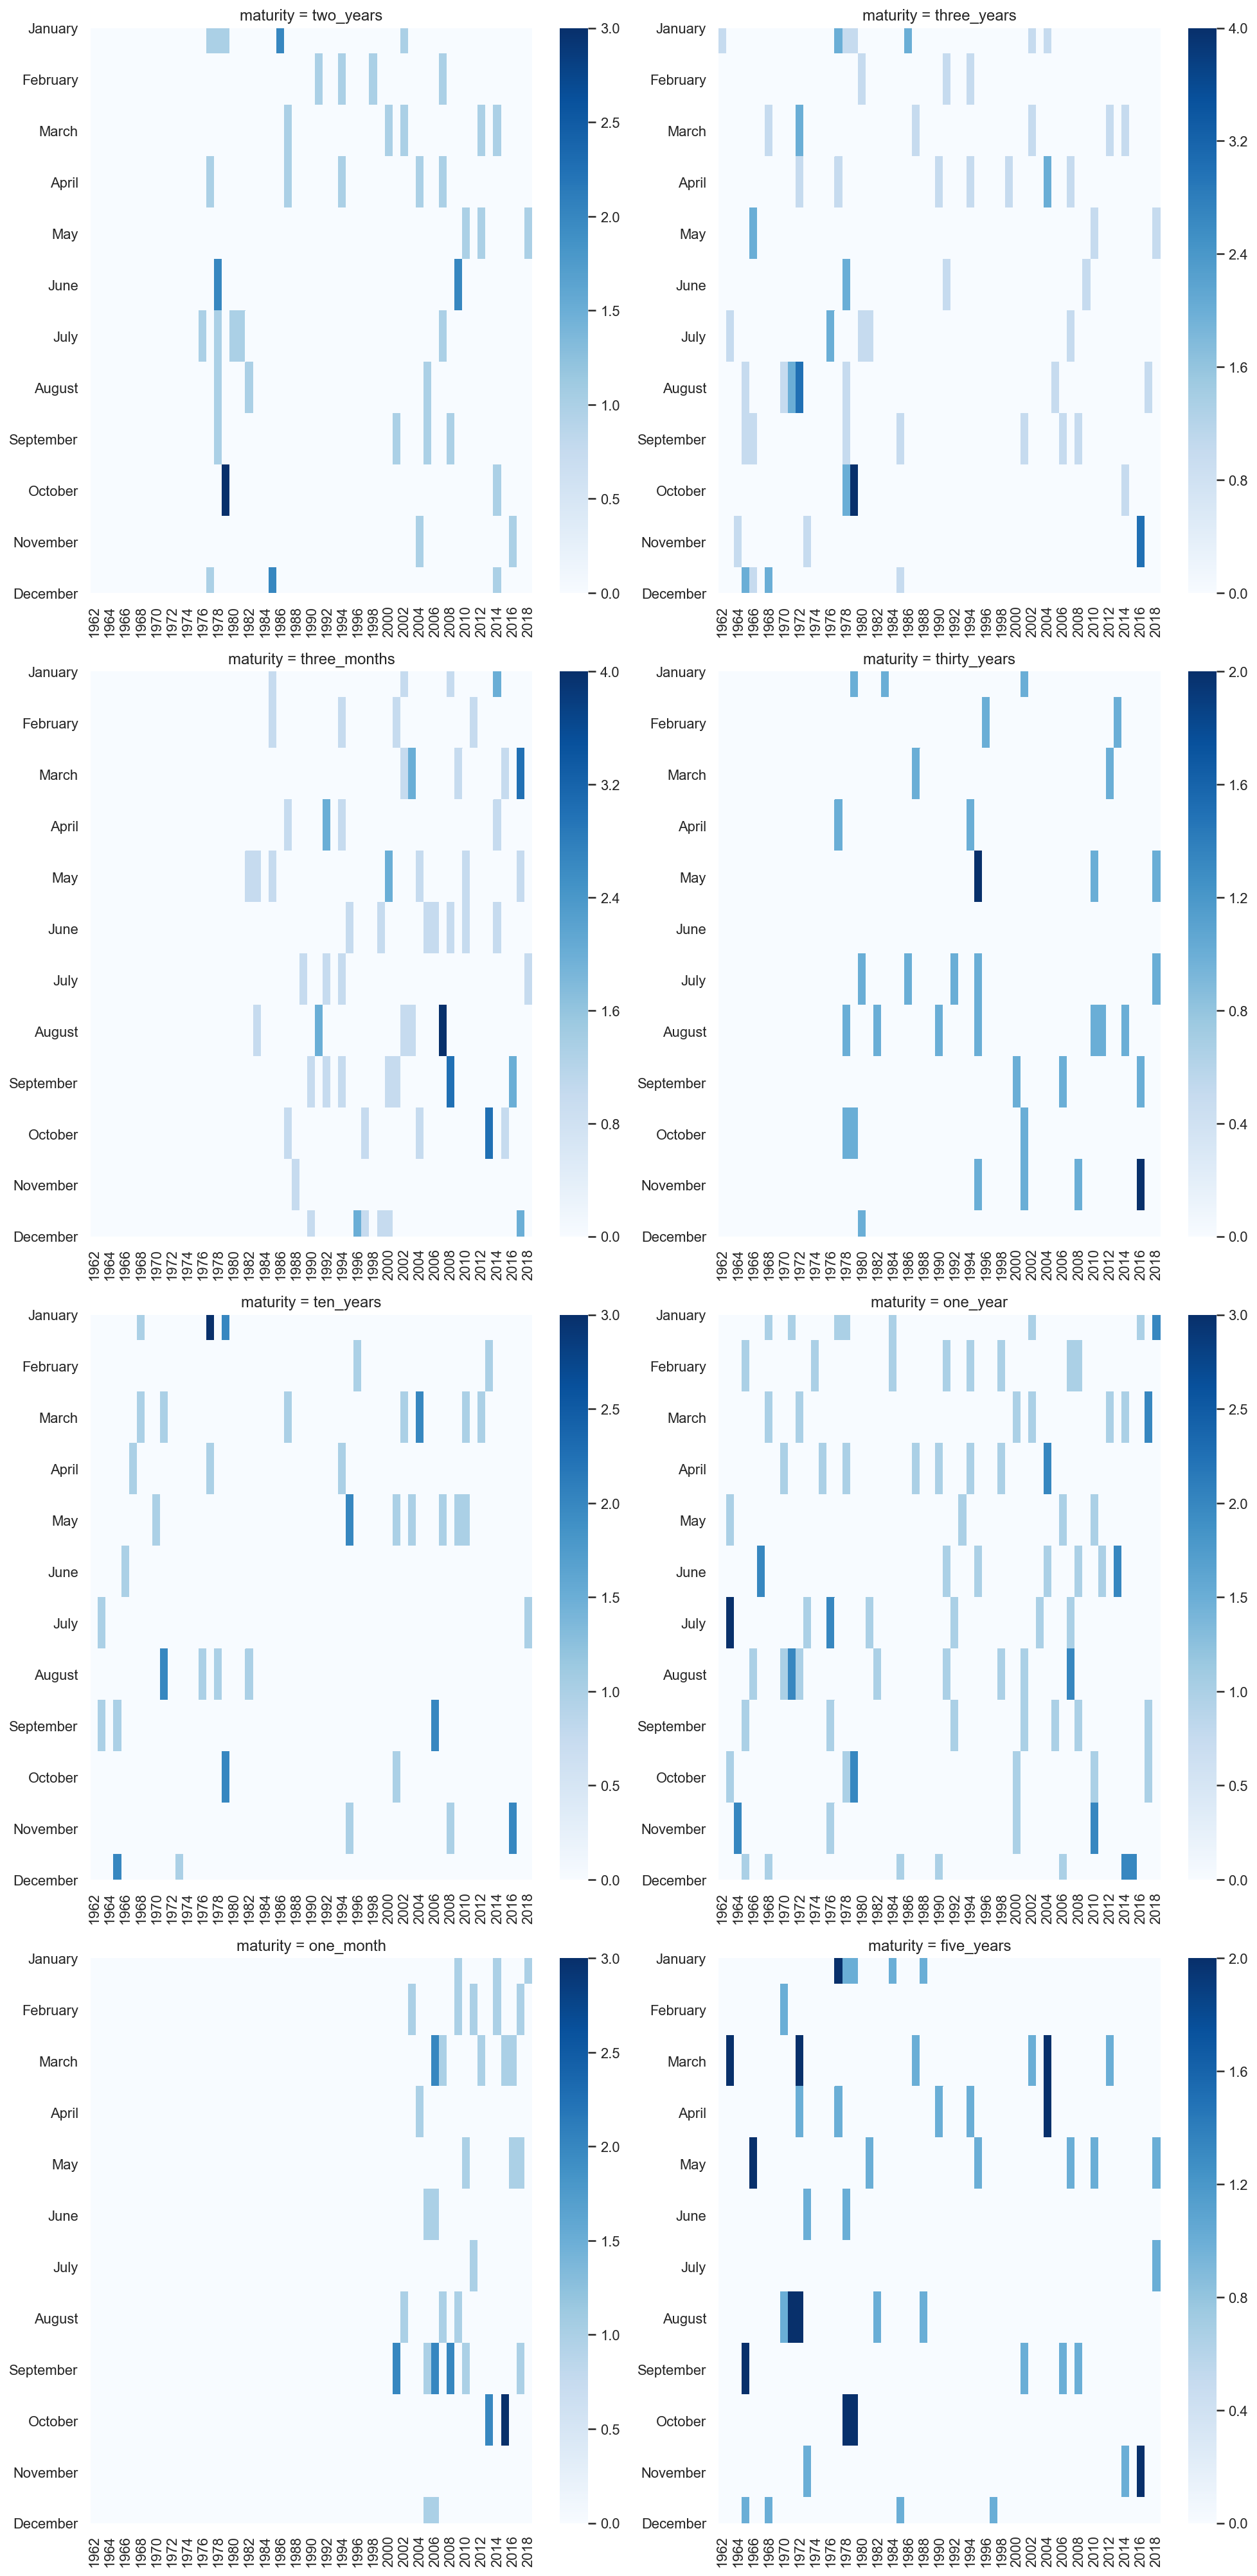

In [368]:
g = sns.FacetGrid(col='maturity', height=7,
            sharey=False, sharex=False, col_wrap=2, data=subset)
g.map_dataframe(heatmap, cmap='Blues')
g.set_yticklabels(rotation=0)
g.fig.tight_layout();

Let's try finding the $3\sigma$ outliers using a yearly window.

In [405]:
monthly_outliers.resample('365D').sum()

one_month  three_months  one_year  two_years  three_years  \
date                                                                    
1962-01-31          0             0         0          0            0   
1963-01-31          0             0         5          0            1   
1964-01-31          0             0         2          0            1   
1965-01-30          0             0         3          0            4   
1966-01-30          0             0         1          0            4   
1967-01-30          0             0         2          0            0   
1968-01-30          0             0         3          0            3   
1969-01-29          0             0         0          0            0   
1970-01-29          0             0         2          0            1   
1971-01-29          0             0         3          0            2   
1972-01-29          0             0         2          0            6   
1973-01-28          0             0         1          0            1   
1974-01-28          0             0         1          0            0   
1975-01-28          0             0         1          0            0   
1976-01-28          0             0         4          1            2   
1977-01-27          0             0         1          3            3   
1978-01-27          0             0         3          6            7   
1979-01-27          0             0         2          4            5   
1980-01-27          0             0         0          1            2   
1981-01-26          0             0         1          1            1   
1982-01-26          0             1         1          1            0   
1983-01-26          0             2         0          0            0   
1984-01-26          0             0         2          0            0   
1985-01-25          0             3         1          2            2   
1986-01-25          0             0         0          2            2   
1987-01-25          0             2         1          2            1   
1988-01-25          0             1         0          0            0   
1989-01-24          0             1         0          0            0   
1990-01-24          0             2         2          0            1   
1991-01-24          0             2         3          1            2   
1992-01-24          0             4         2          0            0   
1993-01-23          0             0         1          0            0   
1994-01-23          0             4         2          2            2   
1995-01-23          0             1         1          0            0   
1996-01-23          0             2         0          0            0   
1997-01-22          0             2         0          0            0   
1998-01-22          0             0         3          1            0   
1999-01-22          0             2         0          0            1   
2000-01-22          0             4         3          1            0   
2001-01-21          2             2         2          1            1   
2002-01-21          1             3         2          2            2   
2003-01-21          1             3         1          0            0   
2004-01-21          1             2         3          2            3   
2005-01-20          3             1         1          2            1   
2006-01-20          6             1         2          0            1   
2007-01-20          2             4         4          3            2   
2008-01-20          2             5         3          1            1   
2009-01-19          3             1         0          2            1   
2010-01-19          2             2         4          1            1   
2011-01-19          2             1         1          0            0   
2012-01-19          1             0         1          2            1   
2013-01-18          2             3         2          0            0   
2014-01-18          2             4         3          3            2 

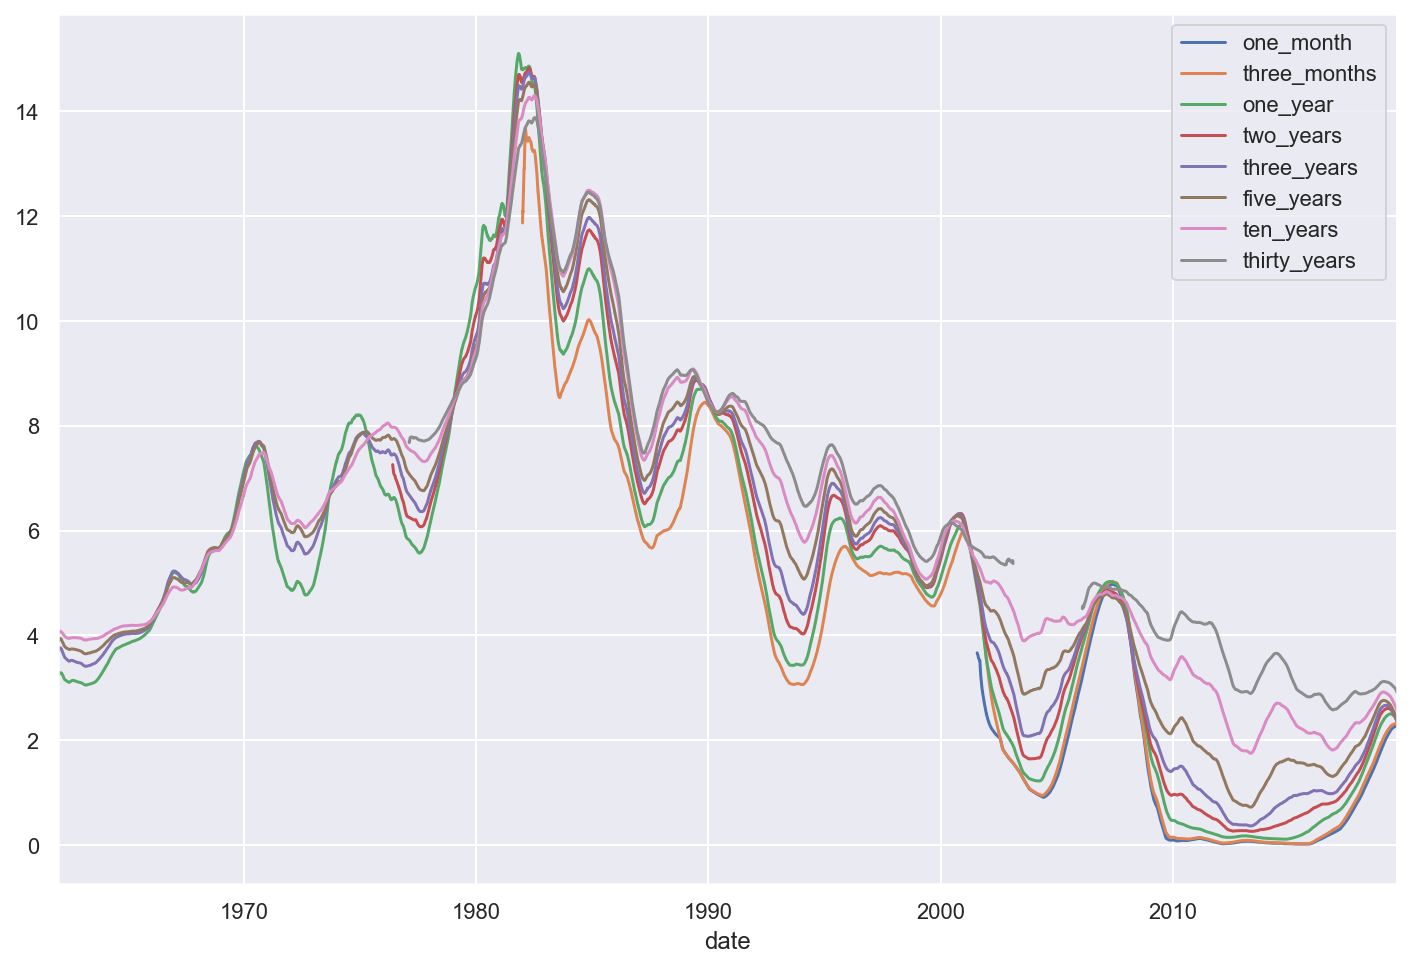

In [389]:
bond_year_means = bonds.rolling(window='365D').mean()
bond_year_means.plot();

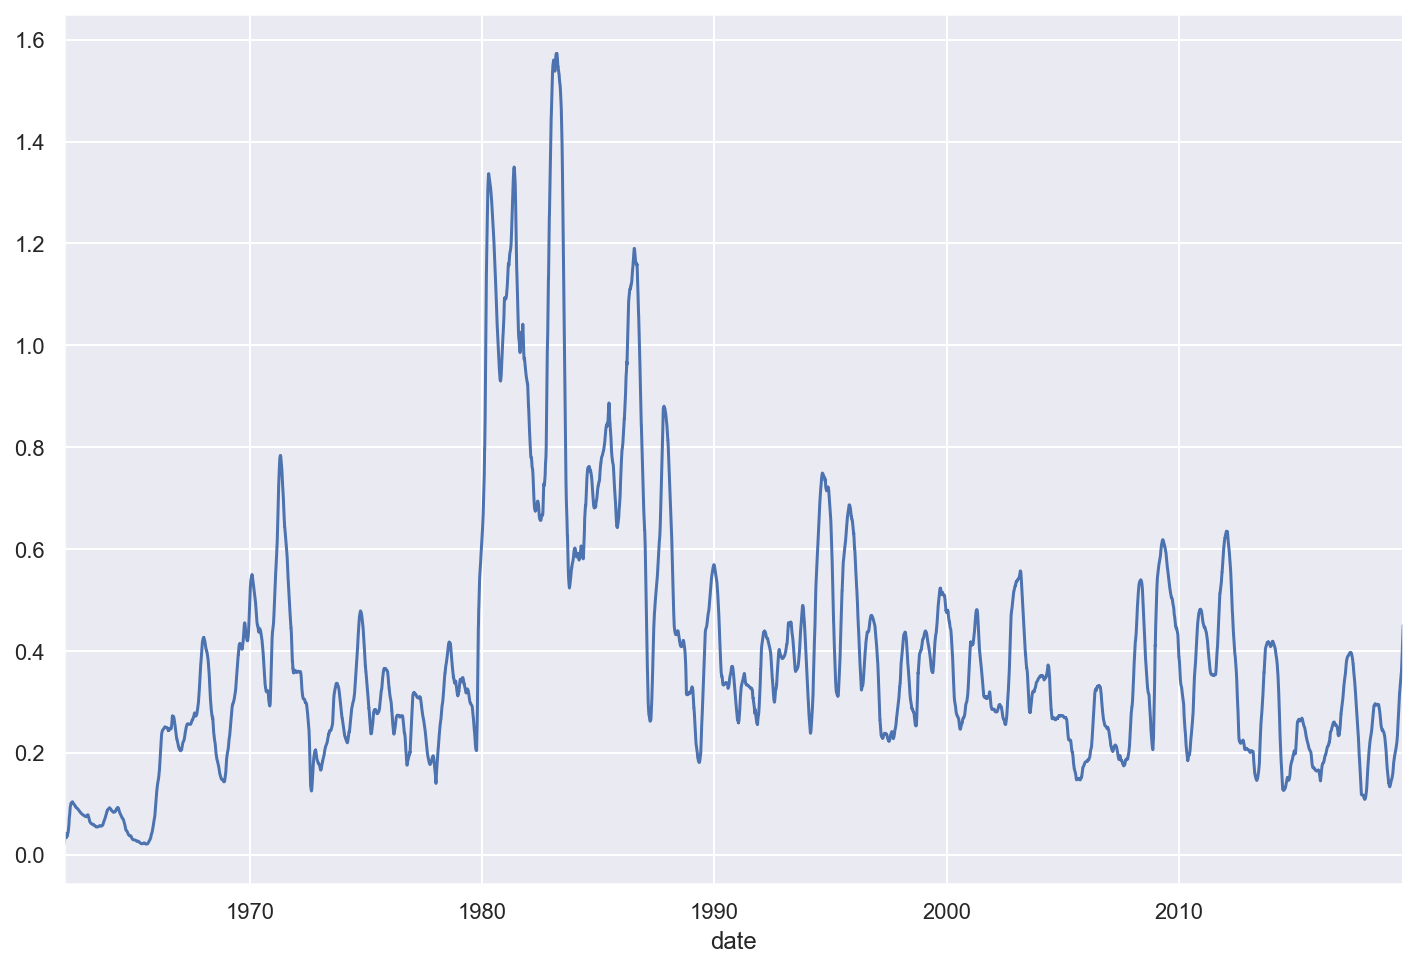

In [390]:
bond_year_stds = bonds.rolling(window='365D').std()
bond_year_stds['ten_years'].plot();

In [392]:
outliers_year = bonds[(bonds - bond_year_means).abs() >= 3 * bond_year_stds]

In [393]:
monthly_year_outliers = outliers_year.resample('M').count()
monthly_year_outliers_tidy = monthly_year_outliers.reset_index().melt(
    id_vars='date', var_name='maturity', value_name='outlier_count')
monthly_year_outliers_tidy['month'] = monthly_year_outliers_tidy['date'].dt.month_name()
monthly_year_outliers_tidy['year'] = monthly_year_outliers_tidy['date'].dt.year
monthly_year_outliers_tidy.head()

date   maturity  outlier_count     month  year
0 1962-01-31  one_month              0   January  1962
1 1962-02-28  one_month              0  February  1962
2 1962-03-31  one_month              0     March  1962
3 1962-04-30  one_month              0     April  1962
4 1962-05-31  one_month              0       May  1962

In [397]:
pivoted_year = monthly_year_outliers_tidy.pivot_table(index=['month', 'maturity'], columns='year')
pivoted_year = pivoted_year.reset_index(level='maturity')
pivoted_year.columns = pivoted_year.columns.droplevel()
pivoted_year.rename(columns={'': 'maturity'}, inplace=True)

In [398]:
subset_year = pivoted_year.drop(columns=2019, axis=0)

In [399]:
subset_year.index = pd.Categorical(subset_year.index, categories=months, ordered=True)
subset_year.sort_index(inplace=True)